- **Note:** Before running any code cells, please update the paths in the notebook so they point to your local copy of the **UOTReg** folder.

In [1]:
# Change this to the path to your folder
result_folder = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'

In [2]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
os.chdir(result_folder)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np

# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load OT functions
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import optimize_T_and_D, optimize_G, optimize_T_and_D_UOT_new
from UOTReg.UOT import UOT_relax_on_2

# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


## Setup data

In [3]:
import scanpy as sc

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
statefate = sc.read(result_folder +  "data/timedata/scrna-statefate/invitro-hvg.h5ad")

# Note: this is the top 1000 HVGs of embryoid, already normalized to 1e4 and log1p transformed
print(statefate.shape)

(130861, 1622)


In [4]:
# Convert PCA array to Pandas data frame
statefate_pc = statefate.obsm['X_pca'][:,0:20]

statefate_pc_df = pd.DataFrame(
    data=statefate_pc,
    index=statefate.obs_names,               # Row index from original AnnData object
    columns=[f"PC{i+1}" for i in range(statefate_pc.shape[1])]  # Column names as PC1, PC2, ...
)

print(type(statefate_pc_df))  # Should be <class 'pandas.DataFrame'>
print(statefate_pc_df.shape)

# get the time snapshots info
cells_meta = statefate.obs
unique_time = statefate.obs['time'].unique().to_list()
print(unique_time)

<class 'pandas.core.frame.DataFrame'>
(130861, 20)
[6, 4, 2]


In [5]:
Y_time_samplers = []

# get samplers for different time snapshots
for id in unique_time:
    X_k = statefate_pc_df[statefate.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

54116
48496
28249


<Figure size 600x200 with 0 Axes>

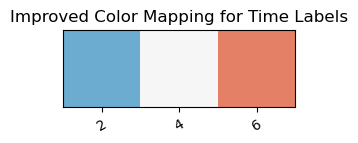

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color gradient with higher contrast
color_palette = sns.color_palette("RdBu_r", n_colors=3)  # Using reversed Red-Blue colormap

# Assign colors to time labels
time_labels = [2, 4, 6]
color_dict = dict(zip(time_labels, color_palette))

# Show the new color mapping
plt.figure(figsize=(6, 2))
sns.palplot(color_palette)
plt.xticks(range(3), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()

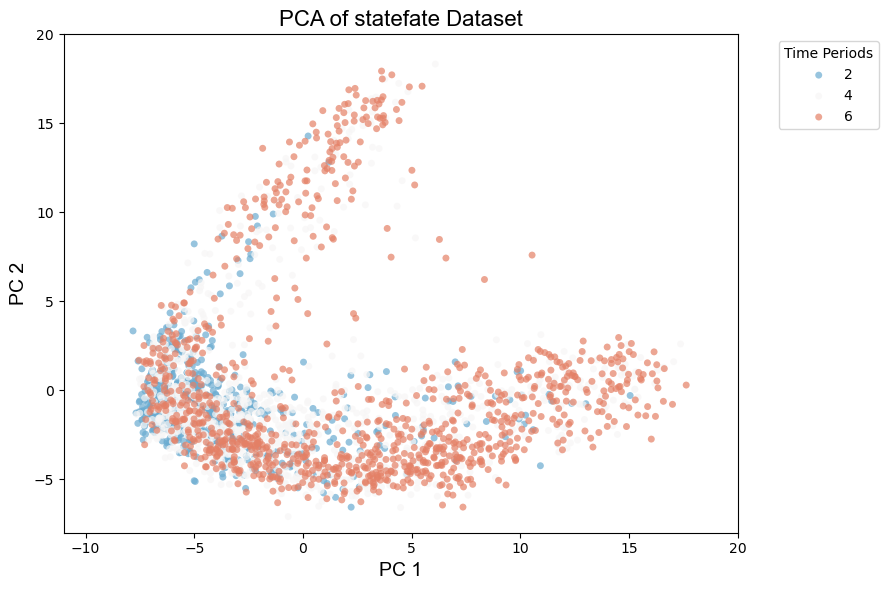

In [7]:
# Extract the first two principal components
pc1 = statefate.obsm['X_pca'][:, 0]
pc2 = statefate.obsm['X_pca'][:, 1]

# Customizable parameters
alpha_values = {2: 0.7, 4: 0.7, 6: 0.7}
z_orders = {2: 3, 4: 2, 6: 1}
marker_size = 25  # Adjust scatter size
font_family = "Arial"  # Change font family
font_size_label = 14   # Font size for axis labels
font_size_title = 16   # Font size for title

# Allow custom axis limits (change as needed)
x_range = (-11, 20)
y_range = (-8, 20)

plt.figure(figsize=(9, 6))

# Plot each time group with no edge color, ensuring points are fully filled
for label in time_labels:
    subset = statefate.obs['time'] == label
    idx = np.where(subset)[0]                # indices of this group
    if idx.shape[0] > 1000:                  # if more than 1000, randomly sample
        idx = np.random.choice(idx, 1000, replace=False)
    plt.scatter(
        pc1[idx], 
        pc2[idx], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_size,  # Adjustable marker size
        alpha=alpha_values[label], 
        edgecolors='none'  # Ensure no border for scatter points
    )

# Move the legend outside the plot
plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Customize font styles
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of statefate Dataset", fontsize=font_size_title, fontfamily=font_family)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()


## New OT maps fitting

In [8]:
# loading the learned generators
size = 256
DIM = 20
dropout_rate = 0.05
G1 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G2 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G3 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
Z_sampler = distributions.StandardNormalSampler(dim=DIM, device="cpu")

print('G params:', np.sum([np.prod(p.shape) for p in G2.parameters()]))

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 

G1.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/estimated_distribution/G_statefate20_256_Day3_40_tau1.pth"))
G2.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/estimated_distribution/G_statefate20_256_Day4_40_tau1.pth"))
G3.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/estimated_distribution/G_statefate20_256_Day5_40_tau1.pth"))

G params: 207892


<All keys matched successfully>

In [9]:
# check learned distributions

G1.eval(); G2.eval(); G3.eval()
data_num = 2000
data_learned1 = G1(Z_sampler.sample(data_num)).detach().numpy()
data_learned2 = G2(Z_sampler.sample(data_num)).detach().numpy()
data_learned3 = G3(Z_sampler.sample(data_num)).detach().numpy()

# Combine original and new time labels in chronological order
time_labels = [
    'Day 2', 'Day 3 (predicted)', 'Day 4 (predicted)', 'Day 5 (predicted)', 'Day 6', 
]

# Define data sources accordingly (assuming you already have the data)
data_dict_ori = {
    'Day 2': statefate.obsm['X_pca'][statefate.obs['time'] == 2],
    'Day 4': statefate.obsm['X_pca'][statefate.obs['time'] == 4],
    'Day 6': statefate.obsm['X_pca'][statefate.obs['time'] == 6],
}

data_dict = {
    'Day 2': statefate.obsm['X_pca'][statefate.obs['time'] == 2],
    'Day 3 (predicted)': data_learned1,
    'Day 4 (predicted)': data_learned2,
    'Day 5 (predicted)': data_learned3,
    'Day 6': statefate.obsm['X_pca'][statefate.obs['time'] == 6]
}

In [10]:
Y_time_samplers = []

unique_time = [2,4,6]
# get samplers for different time snapshots
for id in unique_time:
    X_k = statefate_pc_df[statefate.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

28249
48496
54116


In [11]:
# Construct Y_time_samplers_learned with X_k as a pandas DataFrame
# --- Assumes: torch, numpy already imported; G1..G7, Z_sampler defined & loaded; tensorDataset/tensorSampler available
import pandas as pd
import torch

torch.manual_seed(0)

day_labels = [3,4,5]
generators = [G1, G2, G3]
n_per_day  = 30000
DIM        = Z_sampler.dim if hasattr(Z_sampler, "dim") else 20   # keep DIM consistent
device     = torch.device("cpu")

# Choose column names for the DataFrame
try:
    X_cols = list(statefate_pc_df.columns)[:DIM]
    if len(X_cols) != DIM:
        raise ValueError("statefate_pc_df has incompatible number of columns.")
except Exception:
    X_cols = [f"pc{i+1}" for i in range(DIM)]

for G in generators:
    G.eval()

Y_time_samplers_learned = []
for day, G in zip(day_labels, generators):
    with torch.no_grad():
        Z_t   = Z_sampler.sample(n_per_day)                   # torch [n, DIM]
        X_t   = G(Z_t).detach().to(device).float()            # torch [n, DIM]
        X_np  = X_t.cpu().numpy()                             # numpy [n, DIM]
        X_k   = pd.DataFrame(X_np, columns=X_cols)            # <-- pandas DataFrame

    cells_k = pd.DataFrame({
        "cell_id": [f"d{day}_{i}" for i in range(n_per_day)],
        "time":    day,
        "day":     day
    })

    dataset_k = tensorDataset(X_k, cells_k)
    sampler_k = tensorSampler(dataset_k, device="cpu")
    Y_time_samplers_learned.append(sampler_k)

    print(f"Day {day}: dataset size = {len(dataset_k)}, X_k shape = {X_k.shape}, columns = {X_k.columns[:3].tolist()}...")


Day 3: dataset size = 30000, X_k shape = (30000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 4: dataset size = 30000, X_k shape = (30000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 5: dataset size = 30000, X_k shape = (30000, 20), columns = ['PC1', 'PC2', 'PC3']...


In [12]:
Y_time_samplers_mix = [Y_time_samplers[0], *Y_time_samplers_learned, Y_time_samplers[-1]]

- You can execute the code below to train your own UOTReg maps (ensure the save folder is correctly specified). 

- Alternatively, skip training and use the provided results to reproduce the figures.

In [ ]:
import torch
import os
import pickle

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

# Define hyperparameters
it = 0
BATCH_SIZE = 128
D_ITERS = 300
T_ITERS = 100
save_path = "/Path/to/your/folder"

# Ensure save directory exists
# os.makedirs(save_path, exist_ok=True)

# Loop through the sequence to train OT maps from i -> i+1
for i in range(4):
    print(f"Training OT map from Ysamplers[{i}] to Ysamplers[{i+1}]")

    # Initialize networks
    T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
    D = FFNN(input_size, task_specific_hidden_size_D, n_hidden, 1, bn=False, dropout_rate=dropout_rate)
    
    # Apply weight initialization
    if i == 0 :
        T.apply(weights_init)
        D.apply(weights_init)
    else:
        Tparam = torch.load(save_path + f"/T_map_{i}_to_{i+1}.pt")
        T.load_state_dict(Tparam)
        Dparam = torch.load(save_path + f"/D_{i}_to_{i+1}.pt")
        D.load_state_dict(Dparam)

    # Define optimizers
    T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
    D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

    # Train the OT map
    # it = OT(it, T, D, T_opt, D_opt, Y_time_samplers_mix[i], Y_time_samplers_mix[i + 1], BATCH_SIZE, D_ITERS, T_ITERS)
    it = UOT_relax_on_2(it, T, D, T_opt, D_opt, Y_time_samplers_mix[i], Y_time_samplers_mix[i + 1], BATCH_SIZE, D_ITERS, T_ITERS, tau=20)

    # Save the trained transport map
    # map_filename = os.path.join(save_path, f"T_map_{i}_to_{i+1}.pt")
    # torch.save(T.state_dict(), map_filename)

    map_filename_T = os.path.join(save_path, f"T_map_{i+1}_to_{i+2}.pt")
    filename_D = os.path.join(save_path, f"D_{i+1}_to_{i+2}.pt")
    torch.save(T.state_dict(), map_filename_T)
    torch.save(D.state_dict(), filename_D)

    print(f"Saved OT map from {i+1} to {i+2} at {map_filename_T}")

print("All OT maps have been trained and saved successfully.")


Training OT map from Ysamplers[0] to Ysamplers[1]


  0%|          | 0/300 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 0, d_iter: 0


  0%|          | 1/300 [00:00<04:02,  1.23it/s]


UOT (relax on 2): total_iters: 1, d_iter: 1


KeyboardInterrupt: 

- You can execute the code below to train your own WOT-style maps (ensure the save folder is correctly specified). 

- Alternatively, skip training and use the provided results to reproduce the figures.

In [ ]:
# Directly composing the trajectories

import torch
import os
import pickle

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

# Define hyperparameters
it = 0
BATCH_SIZE = 128
D_ITERS = 200
T_ITERS = 100
save_path = "/Path/to/your/folder"

# Ensure save directory exists
# os.makedirs(save_path, exist_ok=True)

# Loop through the sequence to train OT maps from i -> i+1
for i in range(2):
    print(f"Training OT map from Ysamplers[{i}] to Ysamplers[{i+1}]")

    # Initialize networks
    T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
    D = FFNN(input_size, task_specific_hidden_size_D, n_hidden, 1, bn=False, dropout_rate=dropout_rate)
    
    # Apply weight initialization
    if i == 0 :
        T.apply(weights_init)
        D.apply(weights_init)
    else:
        Tparam = torch.load(save_path + f"/T_map_{i}_to_{i+1}.pt")
        T.load_state_dict(Tparam)
        Dparam = torch.load(save_path + f"/D_{i}_to_{i+1}.pt")
        D.load_state_dict(Dparam)

    # Define optimizers
    T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
    D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

    # Train the OT map
    # it = OT(it, T, D, T_opt, D_opt, Y_time_samplers_mix[i], Y_time_samplers_mix[i + 1], BATCH_SIZE, D_ITERS, T_ITERS)
    it = UOT_relax_on_2(it, T, D, T_opt, D_opt, Y_time_samplers[i], Y_time_samplers[i + 1], BATCH_SIZE, D_ITERS, T_ITERS, tau=20)

    # Save the trained transport map
    # map_filename = os.path.join(save_path, f"T_map_{i}_to_{i+1}.pt")
    # torch.save(T.state_dict(), map_filename)

    map_filename_T = os.path.join(save_path, f"T_map_{i+1}_to_{i+2}.pt")
    filename_D = os.path.join(save_path, f"D_{i+1}_to_{i+2}.pt")
    torch.save(T.state_dict(), map_filename_T)
    torch.save(D.state_dict(), filename_D)

    print(f"Saved OT map from {i+1} to {i+2} at {map_filename_T}")

print("All OT maps have been trained and saved successfully.")


Training OT map from Ysamplers[0] to Ysamplers[1]


  0%|          | 0/200 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 0, d_iter: 0


  0%|          | 1/200 [00:00<02:11,  1.51it/s]

UOT (relax on 2): total_iters: 1, d_iter: 1


  1%|          | 2/200 [00:01<02:07,  1.55it/s]

UOT (relax on 2): total_iters: 2, d_iter: 2


  2%|▏         | 3/200 [00:01<02:06,  1.56it/s]

UOT (relax on 2): total_iters: 3, d_iter: 3


  2%|▏         | 4/200 [00:02<02:04,  1.57it/s]

UOT (relax on 2): total_iters: 4, d_iter: 4


  2%|▎         | 5/200 [00:03<02:02,  1.59it/s]

UOT (relax on 2): total_iters: 5, d_iter: 5


  3%|▎         | 6/200 [00:03<02:01,  1.60it/s]

UOT (relax on 2): total_iters: 6, d_iter: 6


  4%|▎         | 7/200 [00:04<02:00,  1.61it/s]

UOT (relax on 2): total_iters: 7, d_iter: 7


  4%|▍         | 8/200 [00:05<01:59,  1.60it/s]

UOT (relax on 2): total_iters: 8, d_iter: 8


  4%|▍         | 9/200 [00:05<02:00,  1.59it/s]

UOT (relax on 2): total_iters: 9, d_iter: 9


  5%|▌         | 10/200 [00:06<01:58,  1.60it/s]

UOT (relax on 2): total_iters: 10, d_iter: 10


  6%|▌         | 11/200 [00:06<01:57,  1.61it/s]

UOT (relax on 2): total_iters: 11, d_iter: 11


  6%|▌         | 12/200 [00:07<01:56,  1.61it/s]

UOT (relax on 2): total_iters: 12, d_iter: 12


  6%|▋         | 13/200 [00:08<01:56,  1.61it/s]

UOT (relax on 2): total_iters: 13, d_iter: 13


  7%|▋         | 14/200 [00:08<01:56,  1.60it/s]

UOT (relax on 2): total_iters: 14, d_iter: 14


  8%|▊         | 15/200 [00:09<01:55,  1.60it/s]

UOT (relax on 2): total_iters: 15, d_iter: 15


  8%|▊         | 16/200 [00:10<01:54,  1.60it/s]

UOT (relax on 2): total_iters: 16, d_iter: 16


  8%|▊         | 17/200 [00:10<01:53,  1.61it/s]

UOT (relax on 2): total_iters: 17, d_iter: 17


  9%|▉         | 18/200 [00:11<01:52,  1.61it/s]

UOT (relax on 2): total_iters: 18, d_iter: 18


 10%|▉         | 19/200 [00:11<01:52,  1.61it/s]

UOT (relax on 2): total_iters: 19, d_iter: 19


 10%|█         | 20/200 [00:12<01:51,  1.61it/s]

UOT (relax on 2): total_iters: 20, d_iter: 20


 10%|█         | 21/200 [00:13<01:51,  1.61it/s]

UOT (relax on 2): total_iters: 21, d_iter: 21


 11%|█         | 22/200 [00:13<01:52,  1.59it/s]

UOT (relax on 2): total_iters: 22, d_iter: 22


 12%|█▏        | 23/200 [00:14<01:50,  1.60it/s]

UOT (relax on 2): total_iters: 23, d_iter: 23


 12%|█▏        | 24/200 [00:15<01:49,  1.60it/s]

UOT (relax on 2): total_iters: 24, d_iter: 24


 12%|█▎        | 25/200 [00:15<01:49,  1.60it/s]

UOT (relax on 2): total_iters: 25, d_iter: 25


 13%|█▎        | 26/200 [00:16<01:48,  1.60it/s]

UOT (relax on 2): total_iters: 26, d_iter: 26


 14%|█▎        | 27/200 [00:16<01:48,  1.60it/s]

UOT (relax on 2): total_iters: 27, d_iter: 27


 14%|█▍        | 28/200 [00:17<01:47,  1.60it/s]

UOT (relax on 2): total_iters: 28, d_iter: 28


 14%|█▍        | 29/200 [00:18<01:47,  1.60it/s]

UOT (relax on 2): total_iters: 29, d_iter: 29


 15%|█▌        | 30/200 [00:18<01:46,  1.59it/s]

UOT (relax on 2): total_iters: 30, d_iter: 30


 16%|█▌        | 31/200 [00:19<01:46,  1.58it/s]

UOT (relax on 2): total_iters: 31, d_iter: 31


 16%|█▌        | 32/200 [00:20<01:47,  1.56it/s]

UOT (relax on 2): total_iters: 32, d_iter: 32


 16%|█▋        | 33/200 [00:20<01:47,  1.55it/s]

UOT (relax on 2): total_iters: 33, d_iter: 33


 17%|█▋        | 34/200 [00:21<01:46,  1.56it/s]

UOT (relax on 2): total_iters: 34, d_iter: 34


 18%|█▊        | 35/200 [00:21<01:45,  1.57it/s]

UOT (relax on 2): total_iters: 35, d_iter: 35


 18%|█▊        | 36/200 [00:22<01:45,  1.55it/s]

UOT (relax on 2): total_iters: 36, d_iter: 36


 18%|█▊        | 37/200 [00:23<01:44,  1.56it/s]

UOT (relax on 2): total_iters: 37, d_iter: 37


 19%|█▉        | 38/200 [00:23<01:42,  1.59it/s]

UOT (relax on 2): total_iters: 38, d_iter: 38


 20%|█▉        | 39/200 [00:24<01:41,  1.59it/s]

UOT (relax on 2): total_iters: 39, d_iter: 39


 20%|██        | 40/200 [00:25<01:40,  1.59it/s]

UOT (relax on 2): total_iters: 40, d_iter: 40


 20%|██        | 41/200 [00:25<01:39,  1.61it/s]

UOT (relax on 2): total_iters: 41, d_iter: 41


 21%|██        | 42/200 [00:26<01:37,  1.62it/s]

UOT (relax on 2): total_iters: 42, d_iter: 42


 22%|██▏       | 43/200 [00:26<01:37,  1.61it/s]

UOT (relax on 2): total_iters: 43, d_iter: 43


 22%|██▏       | 44/200 [00:27<01:37,  1.60it/s]

UOT (relax on 2): total_iters: 44, d_iter: 44


 22%|██▎       | 45/200 [00:28<01:36,  1.61it/s]

UOT (relax on 2): total_iters: 45, d_iter: 45


 23%|██▎       | 46/200 [00:28<01:35,  1.62it/s]

UOT (relax on 2): total_iters: 46, d_iter: 46


 24%|██▎       | 47/200 [00:29<01:35,  1.61it/s]

UOT (relax on 2): total_iters: 47, d_iter: 47


 24%|██▍       | 48/200 [00:30<01:35,  1.59it/s]

UOT (relax on 2): total_iters: 48, d_iter: 48


 24%|██▍       | 49/200 [00:30<01:33,  1.61it/s]

UOT (relax on 2): total_iters: 49, d_iter: 49


 25%|██▌       | 50/200 [00:31<01:32,  1.62it/s]

UOT (relax on 2): total_iters: 50, d_iter: 50


 26%|██▌       | 51/200 [00:31<01:30,  1.64it/s]

UOT (relax on 2): total_iters: 51, d_iter: 51


 26%|██▌       | 52/200 [00:32<01:29,  1.66it/s]

UOT (relax on 2): total_iters: 52, d_iter: 52


 26%|██▋       | 53/200 [00:33<01:27,  1.67it/s]

UOT (relax on 2): total_iters: 53, d_iter: 53


 27%|██▋       | 54/200 [00:33<01:26,  1.68it/s]

UOT (relax on 2): total_iters: 54, d_iter: 54


 28%|██▊       | 55/200 [00:34<01:26,  1.68it/s]

UOT (relax on 2): total_iters: 55, d_iter: 55


 28%|██▊       | 56/200 [00:34<01:25,  1.69it/s]

UOT (relax on 2): total_iters: 56, d_iter: 56


 28%|██▊       | 57/200 [00:35<01:24,  1.69it/s]

UOT (relax on 2): total_iters: 57, d_iter: 57


 29%|██▉       | 58/200 [00:36<01:24,  1.67it/s]

UOT (relax on 2): total_iters: 58, d_iter: 58


 30%|██▉       | 59/200 [00:36<01:23,  1.69it/s]

UOT (relax on 2): total_iters: 59, d_iter: 59


 30%|███       | 60/200 [00:37<01:22,  1.70it/s]

UOT (relax on 2): total_iters: 60, d_iter: 60


 30%|███       | 61/200 [00:37<01:21,  1.71it/s]

UOT (relax on 2): total_iters: 61, d_iter: 61


 31%|███       | 62/200 [00:38<01:21,  1.69it/s]

UOT (relax on 2): total_iters: 62, d_iter: 62


 32%|███▏      | 63/200 [00:39<01:21,  1.69it/s]

UOT (relax on 2): total_iters: 63, d_iter: 63


 32%|███▏      | 64/200 [00:39<01:20,  1.70it/s]

UOT (relax on 2): total_iters: 64, d_iter: 64


 32%|███▎      | 65/200 [00:40<01:19,  1.70it/s]

UOT (relax on 2): total_iters: 65, d_iter: 65


 33%|███▎      | 66/200 [00:40<01:18,  1.70it/s]

UOT (relax on 2): total_iters: 66, d_iter: 66


 34%|███▎      | 67/200 [00:41<01:19,  1.67it/s]

UOT (relax on 2): total_iters: 67, d_iter: 67


 34%|███▍      | 68/200 [00:42<01:20,  1.64it/s]

UOT (relax on 2): total_iters: 68, d_iter: 68


 34%|███▍      | 69/200 [00:42<01:19,  1.64it/s]

UOT (relax on 2): total_iters: 69, d_iter: 69


 35%|███▌      | 70/200 [00:43<01:17,  1.67it/s]

UOT (relax on 2): total_iters: 70, d_iter: 70


 36%|███▌      | 71/200 [00:43<01:16,  1.68it/s]

UOT (relax on 2): total_iters: 71, d_iter: 71


 36%|███▌      | 72/200 [00:44<01:16,  1.67it/s]

UOT (relax on 2): total_iters: 72, d_iter: 72


 36%|███▋      | 73/200 [00:44<01:15,  1.68it/s]

UOT (relax on 2): total_iters: 73, d_iter: 73


 37%|███▋      | 74/200 [00:45<01:15,  1.67it/s]

UOT (relax on 2): total_iters: 74, d_iter: 74


 38%|███▊      | 75/200 [00:46<01:14,  1.69it/s]

UOT (relax on 2): total_iters: 75, d_iter: 75


 38%|███▊      | 76/200 [00:46<01:14,  1.66it/s]

UOT (relax on 2): total_iters: 76, d_iter: 76


 38%|███▊      | 77/200 [00:47<01:13,  1.67it/s]

UOT (relax on 2): total_iters: 77, d_iter: 77


 39%|███▉      | 78/200 [00:47<01:12,  1.69it/s]

UOT (relax on 2): total_iters: 78, d_iter: 78


 40%|███▉      | 79/200 [00:48<01:12,  1.68it/s]

UOT (relax on 2): total_iters: 79, d_iter: 79


 40%|████      | 80/200 [00:49<01:12,  1.66it/s]

UOT (relax on 2): total_iters: 80, d_iter: 80


 40%|████      | 81/200 [00:49<01:13,  1.62it/s]

UOT (relax on 2): total_iters: 81, d_iter: 81


 41%|████      | 82/200 [00:50<01:15,  1.56it/s]

UOT (relax on 2): total_iters: 82, d_iter: 82


 42%|████▏     | 83/200 [00:51<01:13,  1.59it/s]

UOT (relax on 2): total_iters: 83, d_iter: 83


 42%|████▏     | 84/200 [00:51<01:13,  1.58it/s]

UOT (relax on 2): total_iters: 84, d_iter: 84


 42%|████▎     | 85/200 [00:52<01:12,  1.60it/s]

UOT (relax on 2): total_iters: 85, d_iter: 85


 43%|████▎     | 86/200 [00:53<01:14,  1.53it/s]

UOT (relax on 2): total_iters: 86, d_iter: 86


 44%|████▎     | 87/200 [00:53<01:11,  1.58it/s]

UOT (relax on 2): total_iters: 87, d_iter: 87


 44%|████▍     | 88/200 [00:54<01:09,  1.62it/s]

UOT (relax on 2): total_iters: 88, d_iter: 88


 44%|████▍     | 89/200 [00:54<01:07,  1.65it/s]

UOT (relax on 2): total_iters: 89, d_iter: 89


 45%|████▌     | 90/200 [00:55<01:06,  1.66it/s]

UOT (relax on 2): total_iters: 90, d_iter: 90


 46%|████▌     | 91/200 [00:56<01:04,  1.68it/s]

UOT (relax on 2): total_iters: 91, d_iter: 91


 46%|████▌     | 92/200 [00:56<01:05,  1.64it/s]

UOT (relax on 2): total_iters: 92, d_iter: 92


 46%|████▋     | 93/200 [00:57<01:05,  1.65it/s]

UOT (relax on 2): total_iters: 93, d_iter: 93


 47%|████▋     | 94/200 [00:57<01:04,  1.64it/s]

UOT (relax on 2): total_iters: 94, d_iter: 94


 48%|████▊     | 95/200 [00:58<01:03,  1.65it/s]

UOT (relax on 2): total_iters: 95, d_iter: 95


 48%|████▊     | 96/200 [00:59<01:04,  1.62it/s]

UOT (relax on 2): total_iters: 96, d_iter: 96


 48%|████▊     | 97/200 [00:59<01:03,  1.63it/s]

UOT (relax on 2): total_iters: 97, d_iter: 97


 49%|████▉     | 98/200 [01:00<01:04,  1.57it/s]

UOT (relax on 2): total_iters: 98, d_iter: 98


 50%|████▉     | 99/200 [01:01<01:04,  1.57it/s]

UOT (relax on 2): total_iters: 99, d_iter: 99


 50%|█████     | 100/200 [01:01<01:02,  1.60it/s]

UOT (relax on 2): total_iters: 100, d_iter: 100


 50%|█████     | 101/200 [01:02<01:01,  1.62it/s]

UOT (relax on 2): total_iters: 101, d_iter: 101


 51%|█████     | 102/200 [01:02<00:59,  1.65it/s]

UOT (relax on 2): total_iters: 102, d_iter: 102


 52%|█████▏    | 103/200 [01:03<00:57,  1.67it/s]

UOT (relax on 2): total_iters: 103, d_iter: 103


 52%|█████▏    | 104/200 [01:03<00:56,  1.69it/s]

UOT (relax on 2): total_iters: 104, d_iter: 104


 52%|█████▎    | 105/200 [01:04<00:55,  1.70it/s]

UOT (relax on 2): total_iters: 105, d_iter: 105


 53%|█████▎    | 106/200 [01:05<00:56,  1.68it/s]

UOT (relax on 2): total_iters: 106, d_iter: 106


 54%|█████▎    | 107/200 [01:05<00:55,  1.66it/s]

UOT (relax on 2): total_iters: 107, d_iter: 107


 54%|█████▍    | 108/200 [01:06<00:54,  1.68it/s]

UOT (relax on 2): total_iters: 108, d_iter: 108


 55%|█████▍    | 109/200 [01:06<00:54,  1.68it/s]

UOT (relax on 2): total_iters: 109, d_iter: 109


 55%|█████▌    | 110/200 [01:07<00:54,  1.65it/s]

UOT (relax on 2): total_iters: 110, d_iter: 110


 56%|█████▌    | 111/200 [01:08<00:54,  1.64it/s]

UOT (relax on 2): total_iters: 111, d_iter: 111


 56%|█████▌    | 112/200 [01:08<00:52,  1.67it/s]

UOT (relax on 2): total_iters: 112, d_iter: 112


 56%|█████▋    | 113/200 [01:09<00:51,  1.68it/s]

UOT (relax on 2): total_iters: 113, d_iter: 113


 57%|█████▋    | 114/200 [01:09<00:51,  1.69it/s]

UOT (relax on 2): total_iters: 114, d_iter: 114


 57%|█████▊    | 115/200 [01:10<00:50,  1.69it/s]

UOT (relax on 2): total_iters: 115, d_iter: 115


 58%|█████▊    | 116/200 [01:11<00:49,  1.69it/s]

UOT (relax on 2): total_iters: 116, d_iter: 116


 58%|█████▊    | 117/200 [01:11<00:50,  1.63it/s]

UOT (relax on 2): total_iters: 117, d_iter: 117


 59%|█████▉    | 118/200 [01:12<00:51,  1.61it/s]

UOT (relax on 2): total_iters: 118, d_iter: 118


 60%|█████▉    | 119/200 [01:13<00:49,  1.62it/s]

UOT (relax on 2): total_iters: 119, d_iter: 119


 60%|██████    | 120/200 [01:13<00:49,  1.63it/s]

UOT (relax on 2): total_iters: 120, d_iter: 120


 60%|██████    | 121/200 [01:14<00:48,  1.63it/s]

UOT (relax on 2): total_iters: 121, d_iter: 121


 61%|██████    | 122/200 [01:14<00:47,  1.65it/s]

UOT (relax on 2): total_iters: 122, d_iter: 122


 62%|██████▏   | 123/200 [01:15<00:46,  1.66it/s]

UOT (relax on 2): total_iters: 123, d_iter: 123


 62%|██████▏   | 124/200 [01:16<00:45,  1.66it/s]

UOT (relax on 2): total_iters: 124, d_iter: 124


 62%|██████▎   | 125/200 [01:16<00:45,  1.66it/s]

UOT (relax on 2): total_iters: 125, d_iter: 125


 63%|██████▎   | 126/200 [01:17<00:45,  1.64it/s]

UOT (relax on 2): total_iters: 126, d_iter: 126


 64%|██████▎   | 127/200 [01:17<00:44,  1.66it/s]

UOT (relax on 2): total_iters: 127, d_iter: 127


 64%|██████▍   | 128/200 [01:18<00:43,  1.64it/s]

UOT (relax on 2): total_iters: 128, d_iter: 128


 64%|██████▍   | 129/200 [01:19<00:43,  1.64it/s]

UOT (relax on 2): total_iters: 129, d_iter: 129


 65%|██████▌   | 130/200 [01:19<00:43,  1.60it/s]

UOT (relax on 2): total_iters: 130, d_iter: 130


 66%|██████▌   | 131/200 [01:20<00:43,  1.59it/s]

UOT (relax on 2): total_iters: 131, d_iter: 131


 66%|██████▌   | 132/200 [01:21<00:42,  1.61it/s]

UOT (relax on 2): total_iters: 132, d_iter: 132


 66%|██████▋   | 133/200 [01:21<00:40,  1.64it/s]

UOT (relax on 2): total_iters: 133, d_iter: 133


 67%|██████▋   | 134/200 [01:22<00:40,  1.64it/s]

UOT (relax on 2): total_iters: 134, d_iter: 134


 68%|██████▊   | 135/200 [01:22<00:39,  1.64it/s]

UOT (relax on 2): total_iters: 135, d_iter: 135


 68%|██████▊   | 136/200 [01:23<00:38,  1.66it/s]

UOT (relax on 2): total_iters: 136, d_iter: 136


 68%|██████▊   | 137/200 [01:24<00:37,  1.66it/s]

UOT (relax on 2): total_iters: 137, d_iter: 137


 69%|██████▉   | 138/200 [01:24<00:38,  1.62it/s]

UOT (relax on 2): total_iters: 138, d_iter: 138


 70%|██████▉   | 139/200 [01:25<00:38,  1.59it/s]

UOT (relax on 2): total_iters: 139, d_iter: 139


 70%|███████   | 140/200 [01:25<00:37,  1.61it/s]

UOT (relax on 2): total_iters: 140, d_iter: 140


 70%|███████   | 141/200 [01:26<00:37,  1.56it/s]

UOT (relax on 2): total_iters: 141, d_iter: 141


 71%|███████   | 142/200 [01:27<00:36,  1.59it/s]

UOT (relax on 2): total_iters: 142, d_iter: 142


 72%|███████▏  | 143/200 [01:27<00:35,  1.60it/s]

UOT (relax on 2): total_iters: 143, d_iter: 143


 72%|███████▏  | 144/200 [01:28<00:34,  1.63it/s]

UOT (relax on 2): total_iters: 144, d_iter: 144


 72%|███████▎  | 145/200 [01:29<00:33,  1.63it/s]

UOT (relax on 2): total_iters: 145, d_iter: 145


 73%|███████▎  | 146/200 [01:29<00:33,  1.63it/s]

UOT (relax on 2): total_iters: 146, d_iter: 146


 74%|███████▎  | 147/200 [01:30<00:32,  1.65it/s]

UOT (relax on 2): total_iters: 147, d_iter: 147


 74%|███████▍  | 148/200 [01:30<00:31,  1.67it/s]

UOT (relax on 2): total_iters: 148, d_iter: 148


 74%|███████▍  | 149/200 [01:31<00:30,  1.65it/s]

UOT (relax on 2): total_iters: 149, d_iter: 149


 75%|███████▌  | 150/200 [01:32<00:30,  1.64it/s]

UOT (relax on 2): total_iters: 150, d_iter: 150


 76%|███████▌  | 151/200 [01:32<00:29,  1.64it/s]

UOT (relax on 2): total_iters: 151, d_iter: 151


 76%|███████▌  | 152/200 [01:33<00:29,  1.65it/s]

UOT (relax on 2): total_iters: 152, d_iter: 152


 76%|███████▋  | 153/200 [01:33<00:28,  1.65it/s]

UOT (relax on 2): total_iters: 153, d_iter: 153


 77%|███████▋  | 154/200 [01:34<00:28,  1.63it/s]

UOT (relax on 2): total_iters: 154, d_iter: 154


 78%|███████▊  | 155/200 [01:35<00:27,  1.64it/s]

UOT (relax on 2): total_iters: 155, d_iter: 155


 78%|███████▊  | 156/200 [01:35<00:27,  1.62it/s]

UOT (relax on 2): total_iters: 156, d_iter: 156


 78%|███████▊  | 157/200 [01:36<00:26,  1.60it/s]

UOT (relax on 2): total_iters: 157, d_iter: 157


 79%|███████▉  | 158/200 [01:37<00:26,  1.60it/s]

UOT (relax on 2): total_iters: 158, d_iter: 158


 80%|███████▉  | 159/200 [01:37<00:26,  1.56it/s]

UOT (relax on 2): total_iters: 159, d_iter: 159


 80%|████████  | 160/200 [01:38<00:25,  1.56it/s]

UOT (relax on 2): total_iters: 160, d_iter: 160


 80%|████████  | 161/200 [01:38<00:25,  1.55it/s]

UOT (relax on 2): total_iters: 161, d_iter: 161


 81%|████████  | 162/200 [01:39<00:23,  1.59it/s]

UOT (relax on 2): total_iters: 162, d_iter: 162


 82%|████████▏ | 163/200 [01:40<00:23,  1.59it/s]

UOT (relax on 2): total_iters: 163, d_iter: 163


 82%|████████▏ | 164/200 [01:40<00:22,  1.61it/s]

UOT (relax on 2): total_iters: 164, d_iter: 164


 82%|████████▎ | 165/200 [01:41<00:21,  1.63it/s]

UOT (relax on 2): total_iters: 165, d_iter: 165


 83%|████████▎ | 166/200 [01:41<00:20,  1.64it/s]

UOT (relax on 2): total_iters: 166, d_iter: 166


 84%|████████▎ | 167/200 [01:42<00:19,  1.65it/s]

UOT (relax on 2): total_iters: 167, d_iter: 167


 84%|████████▍ | 168/200 [01:43<00:19,  1.66it/s]

UOT (relax on 2): total_iters: 168, d_iter: 168


 84%|████████▍ | 169/200 [01:43<00:18,  1.67it/s]

UOT (relax on 2): total_iters: 169, d_iter: 169


 85%|████████▌ | 170/200 [01:44<00:18,  1.66it/s]

UOT (relax on 2): total_iters: 170, d_iter: 170


 86%|████████▌ | 171/200 [01:44<00:17,  1.67it/s]

UOT (relax on 2): total_iters: 171, d_iter: 171


 86%|████████▌ | 172/200 [01:45<00:16,  1.68it/s]

UOT (relax on 2): total_iters: 172, d_iter: 172


 86%|████████▋ | 173/200 [01:46<00:16,  1.68it/s]

UOT (relax on 2): total_iters: 173, d_iter: 173


 87%|████████▋ | 174/200 [01:46<00:15,  1.69it/s]

UOT (relax on 2): total_iters: 174, d_iter: 174


 88%|████████▊ | 175/200 [01:47<00:14,  1.69it/s]

UOT (relax on 2): total_iters: 175, d_iter: 175


 88%|████████▊ | 176/200 [01:47<00:14,  1.69it/s]

UOT (relax on 2): total_iters: 176, d_iter: 176


 88%|████████▊ | 177/200 [01:48<00:13,  1.70it/s]

UOT (relax on 2): total_iters: 177, d_iter: 177


 89%|████████▉ | 178/200 [01:49<00:13,  1.68it/s]

UOT (relax on 2): total_iters: 178, d_iter: 178


 90%|████████▉ | 179/200 [01:49<00:12,  1.70it/s]

UOT (relax on 2): total_iters: 179, d_iter: 179


 90%|█████████ | 180/200 [01:50<00:11,  1.70it/s]

UOT (relax on 2): total_iters: 180, d_iter: 180


 90%|█████████ | 181/200 [01:50<00:11,  1.71it/s]

UOT (relax on 2): total_iters: 181, d_iter: 181


 91%|█████████ | 182/200 [01:51<00:10,  1.71it/s]

UOT (relax on 2): total_iters: 182, d_iter: 182


 92%|█████████▏| 183/200 [01:52<00:09,  1.72it/s]

UOT (relax on 2): total_iters: 183, d_iter: 183


 92%|█████████▏| 184/200 [01:52<00:09,  1.71it/s]

UOT (relax on 2): total_iters: 184, d_iter: 184


 92%|█████████▎| 185/200 [01:53<00:08,  1.71it/s]

UOT (relax on 2): total_iters: 185, d_iter: 185


 93%|█████████▎| 186/200 [01:53<00:08,  1.71it/s]

UOT (relax on 2): total_iters: 186, d_iter: 186


 94%|█████████▎| 187/200 [01:54<00:07,  1.69it/s]

UOT (relax on 2): total_iters: 187, d_iter: 187


 94%|█████████▍| 188/200 [01:54<00:07,  1.70it/s]

UOT (relax on 2): total_iters: 188, d_iter: 188


 94%|█████████▍| 189/200 [01:55<00:06,  1.71it/s]

UOT (relax on 2): total_iters: 189, d_iter: 189


 95%|█████████▌| 190/200 [01:56<00:05,  1.71it/s]

UOT (relax on 2): total_iters: 190, d_iter: 190


 96%|█████████▌| 191/200 [01:56<00:05,  1.70it/s]

UOT (relax on 2): total_iters: 191, d_iter: 191


 96%|█████████▌| 192/200 [01:57<00:04,  1.70it/s]

UOT (relax on 2): total_iters: 192, d_iter: 192


 96%|█████████▋| 193/200 [01:57<00:04,  1.67it/s]

UOT (relax on 2): total_iters: 193, d_iter: 193


 97%|█████████▋| 194/200 [01:58<00:03,  1.65it/s]

UOT (relax on 2): total_iters: 194, d_iter: 194


 98%|█████████▊| 195/200 [01:59<00:03,  1.64it/s]

UOT (relax on 2): total_iters: 195, d_iter: 195


 98%|█████████▊| 196/200 [01:59<00:02,  1.64it/s]

UOT (relax on 2): total_iters: 196, d_iter: 196


 98%|█████████▊| 197/200 [02:00<00:01,  1.65it/s]

UOT (relax on 2): total_iters: 197, d_iter: 197


 99%|█████████▉| 198/200 [02:00<00:01,  1.65it/s]

UOT (relax on 2): total_iters: 198, d_iter: 198


100%|█████████▉| 199/200 [02:01<00:00,  1.67it/s]

UOT (relax on 2): total_iters: 199, d_iter: 199


100%|██████████| 200/200 [02:02<00:00,  1.64it/s]


Saved OT map from 1 to 2 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/dynamics/statefate/Final_result/Trajectories/direct20/T_map_1_to_2.pt
Training OT map from Ysamplers[1] to Ysamplers[2]


  0%|          | 0/200 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 200, d_iter: 0


  0%|          | 1/200 [00:00<02:04,  1.60it/s]

UOT (relax on 2): total_iters: 201, d_iter: 1


  1%|          | 2/200 [00:01<02:00,  1.65it/s]

UOT (relax on 2): total_iters: 202, d_iter: 2


  2%|▏         | 3/200 [00:01<02:01,  1.62it/s]

UOT (relax on 2): total_iters: 203, d_iter: 3


  2%|▏         | 4/200 [00:02<01:59,  1.64it/s]

UOT (relax on 2): total_iters: 204, d_iter: 4


  2%|▎         | 5/200 [00:03<01:58,  1.65it/s]

UOT (relax on 2): total_iters: 205, d_iter: 5


  3%|▎         | 6/200 [00:03<01:57,  1.65it/s]

UOT (relax on 2): total_iters: 206, d_iter: 6


  4%|▎         | 7/200 [00:04<01:59,  1.62it/s]

UOT (relax on 2): total_iters: 207, d_iter: 7


  4%|▍         | 8/200 [00:04<01:59,  1.61it/s]

UOT (relax on 2): total_iters: 208, d_iter: 8


  4%|▍         | 9/200 [00:05<01:58,  1.62it/s]

UOT (relax on 2): total_iters: 209, d_iter: 9


  5%|▌         | 10/200 [00:06<01:55,  1.64it/s]

UOT (relax on 2): total_iters: 210, d_iter: 10


  6%|▌         | 11/200 [00:06<01:55,  1.64it/s]

UOT (relax on 2): total_iters: 211, d_iter: 11


  6%|▌         | 12/200 [00:07<01:53,  1.66it/s]

UOT (relax on 2): total_iters: 212, d_iter: 12


  6%|▋         | 13/200 [00:07<01:51,  1.68it/s]

UOT (relax on 2): total_iters: 213, d_iter: 13


  7%|▋         | 14/200 [00:08<01:51,  1.67it/s]

UOT (relax on 2): total_iters: 214, d_iter: 14


  8%|▊         | 15/200 [00:09<01:50,  1.67it/s]

UOT (relax on 2): total_iters: 215, d_iter: 15


  8%|▊         | 16/200 [00:09<01:50,  1.67it/s]

UOT (relax on 2): total_iters: 216, d_iter: 16


  8%|▊         | 17/200 [00:10<01:49,  1.67it/s]

UOT (relax on 2): total_iters: 217, d_iter: 17


  9%|▉         | 18/200 [00:10<01:48,  1.68it/s]

UOT (relax on 2): total_iters: 218, d_iter: 18


 10%|▉         | 19/200 [00:11<01:51,  1.63it/s]

UOT (relax on 2): total_iters: 219, d_iter: 19


 10%|█         | 20/200 [00:12<01:51,  1.62it/s]

UOT (relax on 2): total_iters: 220, d_iter: 20


 10%|█         | 21/200 [00:12<01:54,  1.56it/s]

UOT (relax on 2): total_iters: 221, d_iter: 21


 11%|█         | 22/200 [00:13<01:54,  1.56it/s]

UOT (relax on 2): total_iters: 222, d_iter: 22


 12%|█▏        | 23/200 [00:14<01:50,  1.60it/s]

UOT (relax on 2): total_iters: 223, d_iter: 23


 12%|█▏        | 24/200 [00:14<01:47,  1.63it/s]

UOT (relax on 2): total_iters: 224, d_iter: 24


 12%|█▎        | 25/200 [00:15<01:46,  1.65it/s]

UOT (relax on 2): total_iters: 225, d_iter: 25


 13%|█▎        | 26/200 [00:15<01:44,  1.66it/s]

UOT (relax on 2): total_iters: 226, d_iter: 26


 14%|█▎        | 27/200 [00:16<01:43,  1.67it/s]

UOT (relax on 2): total_iters: 227, d_iter: 27


 14%|█▍        | 28/200 [00:17<01:43,  1.67it/s]

UOT (relax on 2): total_iters: 228, d_iter: 28


 14%|█▍        | 29/200 [00:17<01:41,  1.68it/s]

UOT (relax on 2): total_iters: 229, d_iter: 29


 15%|█▌        | 30/200 [00:18<01:45,  1.61it/s]

UOT (relax on 2): total_iters: 230, d_iter: 30


 16%|█▌        | 31/200 [00:18<01:43,  1.64it/s]

UOT (relax on 2): total_iters: 231, d_iter: 31


 16%|█▌        | 32/200 [00:19<01:45,  1.59it/s]

UOT (relax on 2): total_iters: 232, d_iter: 32


 16%|█▋        | 33/200 [00:20<01:43,  1.61it/s]

UOT (relax on 2): total_iters: 233, d_iter: 33


 17%|█▋        | 34/200 [00:20<01:42,  1.63it/s]

UOT (relax on 2): total_iters: 234, d_iter: 34


 18%|█▊        | 35/200 [00:21<01:40,  1.64it/s]

UOT (relax on 2): total_iters: 235, d_iter: 35


 18%|█▊        | 36/200 [00:22<01:40,  1.63it/s]

UOT (relax on 2): total_iters: 236, d_iter: 36


 18%|█▊        | 37/200 [00:22<01:38,  1.66it/s]

UOT (relax on 2): total_iters: 237, d_iter: 37


 19%|█▉        | 38/200 [00:23<01:40,  1.61it/s]

UOT (relax on 2): total_iters: 238, d_iter: 38


 20%|█▉        | 39/200 [00:23<01:41,  1.59it/s]

UOT (relax on 2): total_iters: 239, d_iter: 39


 20%|██        | 40/200 [00:24<01:39,  1.60it/s]

UOT (relax on 2): total_iters: 240, d_iter: 40


 20%|██        | 41/200 [00:25<01:37,  1.64it/s]

UOT (relax on 2): total_iters: 241, d_iter: 41


 21%|██        | 42/200 [00:25<01:34,  1.67it/s]

UOT (relax on 2): total_iters: 242, d_iter: 42


 22%|██▏       | 43/200 [00:26<01:33,  1.68it/s]

UOT (relax on 2): total_iters: 243, d_iter: 43


 22%|██▏       | 44/200 [00:26<01:33,  1.67it/s]

UOT (relax on 2): total_iters: 244, d_iter: 44


 22%|██▎       | 45/200 [00:27<01:31,  1.69it/s]

UOT (relax on 2): total_iters: 245, d_iter: 45


 23%|██▎       | 46/200 [00:28<01:31,  1.68it/s]

UOT (relax on 2): total_iters: 246, d_iter: 46


 24%|██▎       | 47/200 [00:28<01:35,  1.61it/s]

UOT (relax on 2): total_iters: 247, d_iter: 47


 24%|██▍       | 48/200 [00:29<01:33,  1.62it/s]

UOT (relax on 2): total_iters: 248, d_iter: 48


 24%|██▍       | 49/200 [00:29<01:35,  1.58it/s]

UOT (relax on 2): total_iters: 249, d_iter: 49


 25%|██▌       | 50/200 [00:30<01:32,  1.62it/s]

UOT (relax on 2): total_iters: 250, d_iter: 50


 26%|██▌       | 51/200 [00:31<01:31,  1.62it/s]

UOT (relax on 2): total_iters: 251, d_iter: 51


 26%|██▌       | 52/200 [00:31<01:32,  1.60it/s]

UOT (relax on 2): total_iters: 252, d_iter: 52


 26%|██▋       | 53/200 [00:32<01:30,  1.62it/s]

UOT (relax on 2): total_iters: 253, d_iter: 53


 27%|██▋       | 54/200 [00:33<01:34,  1.55it/s]

UOT (relax on 2): total_iters: 254, d_iter: 54


 28%|██▊       | 55/200 [00:33<01:32,  1.57it/s]

UOT (relax on 2): total_iters: 255, d_iter: 55


 28%|██▊       | 56/200 [00:34<01:29,  1.61it/s]

UOT (relax on 2): total_iters: 256, d_iter: 56


 28%|██▊       | 57/200 [00:34<01:27,  1.64it/s]

UOT (relax on 2): total_iters: 257, d_iter: 57


 29%|██▉       | 58/200 [00:35<01:26,  1.64it/s]

UOT (relax on 2): total_iters: 258, d_iter: 58


 30%|██▉       | 59/200 [00:36<01:25,  1.65it/s]

UOT (relax on 2): total_iters: 259, d_iter: 59


 30%|███       | 60/200 [00:36<01:24,  1.65it/s]

UOT (relax on 2): total_iters: 260, d_iter: 60


 30%|███       | 61/200 [00:37<01:23,  1.67it/s]

UOT (relax on 2): total_iters: 261, d_iter: 61


 31%|███       | 62/200 [00:37<01:22,  1.68it/s]

UOT (relax on 2): total_iters: 262, d_iter: 62


 32%|███▏      | 63/200 [00:38<01:21,  1.68it/s]

UOT (relax on 2): total_iters: 263, d_iter: 63


 32%|███▏      | 64/200 [00:39<01:20,  1.69it/s]

UOT (relax on 2): total_iters: 264, d_iter: 64


 32%|███▎      | 65/200 [00:39<01:20,  1.68it/s]

UOT (relax on 2): total_iters: 265, d_iter: 65


 33%|███▎      | 66/200 [00:40<01:21,  1.64it/s]

UOT (relax on 2): total_iters: 266, d_iter: 66


 34%|███▎      | 67/200 [00:40<01:21,  1.64it/s]

UOT (relax on 2): total_iters: 267, d_iter: 67


 34%|███▍      | 68/200 [00:41<01:19,  1.65it/s]

UOT (relax on 2): total_iters: 268, d_iter: 68


 34%|███▍      | 69/200 [00:42<01:19,  1.65it/s]

UOT (relax on 2): total_iters: 269, d_iter: 69


 35%|███▌      | 70/200 [00:42<01:17,  1.68it/s]

UOT (relax on 2): total_iters: 270, d_iter: 70


 36%|███▌      | 71/200 [00:43<01:17,  1.65it/s]

UOT (relax on 2): total_iters: 271, d_iter: 71


 36%|███▌      | 72/200 [00:43<01:17,  1.65it/s]

UOT (relax on 2): total_iters: 272, d_iter: 72


 36%|███▋      | 73/200 [00:44<01:16,  1.67it/s]

UOT (relax on 2): total_iters: 273, d_iter: 73


 37%|███▋      | 74/200 [00:45<01:15,  1.67it/s]

UOT (relax on 2): total_iters: 274, d_iter: 74


 38%|███▊      | 75/200 [00:45<01:14,  1.69it/s]

UOT (relax on 2): total_iters: 275, d_iter: 75


 38%|███▊      | 76/200 [00:46<01:13,  1.69it/s]

UOT (relax on 2): total_iters: 276, d_iter: 76


 38%|███▊      | 77/200 [00:46<01:12,  1.70it/s]

UOT (relax on 2): total_iters: 277, d_iter: 77


 39%|███▉      | 78/200 [00:47<01:11,  1.70it/s]

UOT (relax on 2): total_iters: 278, d_iter: 78


 40%|███▉      | 79/200 [00:48<01:11,  1.70it/s]

UOT (relax on 2): total_iters: 279, d_iter: 79


 40%|████      | 80/200 [00:48<01:10,  1.71it/s]

UOT (relax on 2): total_iters: 280, d_iter: 80


 40%|████      | 81/200 [00:49<01:10,  1.69it/s]

UOT (relax on 2): total_iters: 281, d_iter: 81


 41%|████      | 82/200 [00:49<01:09,  1.70it/s]

UOT (relax on 2): total_iters: 282, d_iter: 82


 42%|████▏     | 83/200 [00:50<01:08,  1.70it/s]

UOT (relax on 2): total_iters: 283, d_iter: 83


 42%|████▏     | 84/200 [00:50<01:07,  1.71it/s]

UOT (relax on 2): total_iters: 284, d_iter: 84


 42%|████▎     | 85/200 [00:51<01:06,  1.72it/s]

UOT (relax on 2): total_iters: 285, d_iter: 85


 43%|████▎     | 86/200 [00:52<01:05,  1.73it/s]

UOT (relax on 2): total_iters: 286, d_iter: 86


 44%|████▎     | 87/200 [00:52<01:04,  1.74it/s]

UOT (relax on 2): total_iters: 287, d_iter: 87


 44%|████▍     | 88/200 [00:53<01:04,  1.75it/s]

UOT (relax on 2): total_iters: 288, d_iter: 88


 44%|████▍     | 89/200 [00:53<01:03,  1.75it/s]

UOT (relax on 2): total_iters: 289, d_iter: 89


 45%|████▌     | 90/200 [00:54<01:03,  1.73it/s]

UOT (relax on 2): total_iters: 290, d_iter: 90


 46%|████▌     | 91/200 [00:55<01:03,  1.73it/s]

UOT (relax on 2): total_iters: 291, d_iter: 91


 46%|████▌     | 92/200 [00:55<01:03,  1.69it/s]

UOT (relax on 2): total_iters: 292, d_iter: 92


 46%|████▋     | 93/200 [00:56<01:02,  1.70it/s]

UOT (relax on 2): total_iters: 293, d_iter: 93


 47%|████▋     | 94/200 [00:56<01:02,  1.71it/s]

UOT (relax on 2): total_iters: 294, d_iter: 94


 48%|████▊     | 95/200 [00:57<01:01,  1.71it/s]

UOT (relax on 2): total_iters: 295, d_iter: 95


 48%|████▊     | 96/200 [00:57<01:01,  1.69it/s]

UOT (relax on 2): total_iters: 296, d_iter: 96


 48%|████▊     | 97/200 [00:58<01:01,  1.68it/s]

UOT (relax on 2): total_iters: 297, d_iter: 97


 49%|████▉     | 98/200 [00:59<01:00,  1.68it/s]

UOT (relax on 2): total_iters: 298, d_iter: 98


 50%|████▉     | 99/200 [00:59<00:59,  1.69it/s]

UOT (relax on 2): total_iters: 299, d_iter: 99


 50%|█████     | 100/200 [01:00<00:58,  1.70it/s]

UOT (relax on 2): total_iters: 300, d_iter: 100


 50%|█████     | 101/200 [01:00<00:57,  1.71it/s]

UOT (relax on 2): total_iters: 301, d_iter: 101


 51%|█████     | 102/200 [01:01<00:57,  1.69it/s]

UOT (relax on 2): total_iters: 302, d_iter: 102


 52%|█████▏    | 103/200 [01:02<00:57,  1.70it/s]

UOT (relax on 2): total_iters: 303, d_iter: 103


 52%|█████▏    | 104/200 [01:02<00:56,  1.70it/s]

UOT (relax on 2): total_iters: 304, d_iter: 104


 52%|█████▎    | 105/200 [01:03<00:55,  1.71it/s]

UOT (relax on 2): total_iters: 305, d_iter: 105


 53%|█████▎    | 106/200 [01:03<00:55,  1.70it/s]

UOT (relax on 2): total_iters: 306, d_iter: 106


 54%|█████▎    | 107/200 [01:04<00:54,  1.70it/s]

UOT (relax on 2): total_iters: 307, d_iter: 107


 54%|█████▍    | 108/200 [01:05<00:55,  1.67it/s]

UOT (relax on 2): total_iters: 308, d_iter: 108


 55%|█████▍    | 109/200 [01:05<00:54,  1.68it/s]

UOT (relax on 2): total_iters: 309, d_iter: 109


 55%|█████▌    | 110/200 [01:06<00:54,  1.66it/s]

UOT (relax on 2): total_iters: 310, d_iter: 110


 56%|█████▌    | 111/200 [01:06<00:53,  1.68it/s]

UOT (relax on 2): total_iters: 311, d_iter: 111


 56%|█████▌    | 112/200 [01:07<00:52,  1.68it/s]

UOT (relax on 2): total_iters: 312, d_iter: 112


 56%|█████▋    | 113/200 [01:08<00:51,  1.69it/s]

UOT (relax on 2): total_iters: 313, d_iter: 113


 57%|█████▋    | 114/200 [01:08<00:50,  1.69it/s]

UOT (relax on 2): total_iters: 314, d_iter: 114


 57%|█████▊    | 115/200 [01:09<00:49,  1.71it/s]

UOT (relax on 2): total_iters: 315, d_iter: 115


 58%|█████▊    | 116/200 [01:09<00:48,  1.72it/s]

UOT (relax on 2): total_iters: 316, d_iter: 116


 58%|█████▊    | 117/200 [01:10<00:47,  1.73it/s]

UOT (relax on 2): total_iters: 317, d_iter: 117


 59%|█████▉    | 118/200 [01:10<00:47,  1.74it/s]

UOT (relax on 2): total_iters: 318, d_iter: 118


 60%|█████▉    | 119/200 [01:11<00:46,  1.74it/s]

UOT (relax on 2): total_iters: 319, d_iter: 119


 60%|██████    | 120/200 [01:12<00:46,  1.70it/s]

UOT (relax on 2): total_iters: 320, d_iter: 120


 60%|██████    | 121/200 [01:12<00:47,  1.68it/s]

UOT (relax on 2): total_iters: 321, d_iter: 121


 61%|██████    | 122/200 [01:13<00:47,  1.65it/s]

UOT (relax on 2): total_iters: 322, d_iter: 122


 62%|██████▏   | 123/200 [01:13<00:46,  1.65it/s]

UOT (relax on 2): total_iters: 323, d_iter: 123


 62%|██████▏   | 124/200 [01:14<00:46,  1.65it/s]

UOT (relax on 2): total_iters: 324, d_iter: 124


 62%|██████▎   | 125/200 [01:15<00:45,  1.65it/s]

UOT (relax on 2): total_iters: 325, d_iter: 125


 63%|██████▎   | 126/200 [01:15<00:44,  1.65it/s]

UOT (relax on 2): total_iters: 326, d_iter: 126


 64%|██████▎   | 127/200 [01:16<00:44,  1.65it/s]

UOT (relax on 2): total_iters: 327, d_iter: 127


 64%|██████▍   | 128/200 [01:16<00:43,  1.65it/s]

UOT (relax on 2): total_iters: 328, d_iter: 128


 64%|██████▍   | 129/200 [01:17<00:42,  1.65it/s]

UOT (relax on 2): total_iters: 329, d_iter: 129


 65%|██████▌   | 130/200 [01:18<00:42,  1.65it/s]

UOT (relax on 2): total_iters: 330, d_iter: 130


 66%|██████▌   | 131/200 [01:18<00:41,  1.65it/s]

UOT (relax on 2): total_iters: 331, d_iter: 131


 66%|██████▌   | 132/200 [01:19<00:41,  1.65it/s]

UOT (relax on 2): total_iters: 332, d_iter: 132


 66%|██████▋   | 133/200 [01:20<00:40,  1.66it/s]

UOT (relax on 2): total_iters: 333, d_iter: 133


 67%|██████▋   | 134/200 [01:20<00:40,  1.64it/s]

UOT (relax on 2): total_iters: 334, d_iter: 134


 68%|██████▊   | 135/200 [01:21<00:39,  1.64it/s]

UOT (relax on 2): total_iters: 335, d_iter: 135


 68%|██████▊   | 136/200 [01:21<00:38,  1.65it/s]

UOT (relax on 2): total_iters: 336, d_iter: 136


 68%|██████▊   | 137/200 [01:22<00:38,  1.64it/s]

UOT (relax on 2): total_iters: 337, d_iter: 137


 69%|██████▉   | 138/200 [01:23<00:37,  1.64it/s]

UOT (relax on 2): total_iters: 338, d_iter: 138


 70%|██████▉   | 139/200 [01:23<00:37,  1.64it/s]

UOT (relax on 2): total_iters: 339, d_iter: 139


 70%|███████   | 140/200 [01:24<00:36,  1.65it/s]

UOT (relax on 2): total_iters: 340, d_iter: 140


 70%|███████   | 141/200 [01:24<00:35,  1.64it/s]

UOT (relax on 2): total_iters: 341, d_iter: 141


 71%|███████   | 142/200 [01:25<00:35,  1.65it/s]

UOT (relax on 2): total_iters: 342, d_iter: 142


 72%|███████▏  | 143/200 [01:26<00:34,  1.64it/s]

UOT (relax on 2): total_iters: 343, d_iter: 143


 72%|███████▏  | 144/200 [01:26<00:34,  1.64it/s]

UOT (relax on 2): total_iters: 344, d_iter: 144


 72%|███████▎  | 145/200 [01:27<00:33,  1.63it/s]

UOT (relax on 2): total_iters: 345, d_iter: 145


 73%|███████▎  | 146/200 [01:27<00:32,  1.64it/s]

UOT (relax on 2): total_iters: 346, d_iter: 146


 74%|███████▎  | 147/200 [01:28<00:32,  1.65it/s]

UOT (relax on 2): total_iters: 347, d_iter: 147


 74%|███████▍  | 148/200 [01:29<00:31,  1.65it/s]

UOT (relax on 2): total_iters: 348, d_iter: 148


 74%|███████▍  | 149/200 [01:29<00:31,  1.64it/s]

UOT (relax on 2): total_iters: 349, d_iter: 149


 75%|███████▌  | 150/200 [01:30<00:30,  1.64it/s]

UOT (relax on 2): total_iters: 350, d_iter: 150


 76%|███████▌  | 151/200 [01:30<00:29,  1.64it/s]

UOT (relax on 2): total_iters: 351, d_iter: 151


 76%|███████▌  | 152/200 [01:31<00:29,  1.64it/s]

UOT (relax on 2): total_iters: 352, d_iter: 152


 76%|███████▋  | 153/200 [01:32<00:28,  1.63it/s]

UOT (relax on 2): total_iters: 353, d_iter: 153


 77%|███████▋  | 154/200 [01:32<00:28,  1.61it/s]

UOT (relax on 2): total_iters: 354, d_iter: 154


 78%|███████▊  | 155/200 [01:33<00:27,  1.63it/s]

UOT (relax on 2): total_iters: 355, d_iter: 155


 78%|███████▊  | 156/200 [01:34<00:26,  1.63it/s]

UOT (relax on 2): total_iters: 356, d_iter: 156


 78%|███████▊  | 157/200 [01:34<00:26,  1.64it/s]

UOT (relax on 2): total_iters: 357, d_iter: 157


 79%|███████▉  | 158/200 [01:35<00:25,  1.64it/s]

UOT (relax on 2): total_iters: 358, d_iter: 158


 80%|███████▉  | 159/200 [01:35<00:25,  1.63it/s]

UOT (relax on 2): total_iters: 359, d_iter: 159


 80%|████████  | 160/200 [01:36<00:24,  1.61it/s]

UOT (relax on 2): total_iters: 360, d_iter: 160


 80%|████████  | 161/200 [01:37<00:24,  1.61it/s]

UOT (relax on 2): total_iters: 361, d_iter: 161


 81%|████████  | 162/200 [01:37<00:23,  1.60it/s]

UOT (relax on 2): total_iters: 362, d_iter: 162


 82%|████████▏ | 163/200 [01:38<00:23,  1.60it/s]

UOT (relax on 2): total_iters: 363, d_iter: 163


 82%|████████▏ | 164/200 [01:39<00:23,  1.56it/s]

UOT (relax on 2): total_iters: 364, d_iter: 164


 82%|████████▎ | 165/200 [01:39<00:22,  1.53it/s]

UOT (relax on 2): total_iters: 365, d_iter: 165


 83%|████████▎ | 166/200 [01:40<00:21,  1.56it/s]

UOT (relax on 2): total_iters: 366, d_iter: 166


 84%|████████▎ | 167/200 [01:40<00:20,  1.60it/s]

UOT (relax on 2): total_iters: 367, d_iter: 167


 84%|████████▍ | 168/200 [01:41<00:19,  1.62it/s]

UOT (relax on 2): total_iters: 368, d_iter: 168


 84%|████████▍ | 169/200 [01:42<00:18,  1.65it/s]

UOT (relax on 2): total_iters: 369, d_iter: 169


 85%|████████▌ | 170/200 [01:42<00:18,  1.66it/s]

UOT (relax on 2): total_iters: 370, d_iter: 170


 86%|████████▌ | 171/200 [01:43<00:17,  1.67it/s]

UOT (relax on 2): total_iters: 371, d_iter: 171


 86%|████████▌ | 172/200 [01:43<00:16,  1.68it/s]

UOT (relax on 2): total_iters: 372, d_iter: 172


 86%|████████▋ | 173/200 [01:44<00:15,  1.69it/s]

UOT (relax on 2): total_iters: 373, d_iter: 173


 87%|████████▋ | 174/200 [01:45<00:15,  1.66it/s]

UOT (relax on 2): total_iters: 374, d_iter: 174


 88%|████████▊ | 175/200 [01:45<00:14,  1.67it/s]

UOT (relax on 2): total_iters: 375, d_iter: 175


 88%|████████▊ | 176/200 [01:46<00:14,  1.68it/s]

UOT (relax on 2): total_iters: 376, d_iter: 176


 88%|████████▊ | 177/200 [01:46<00:13,  1.68it/s]

UOT (relax on 2): total_iters: 377, d_iter: 177


 89%|████████▉ | 178/200 [01:47<00:13,  1.64it/s]

UOT (relax on 2): total_iters: 378, d_iter: 178


 90%|████████▉ | 179/200 [01:48<00:12,  1.64it/s]

UOT (relax on 2): total_iters: 379, d_iter: 179


 90%|█████████ | 180/200 [01:48<00:12,  1.66it/s]

UOT (relax on 2): total_iters: 380, d_iter: 180


 90%|█████████ | 181/200 [01:49<00:11,  1.61it/s]

UOT (relax on 2): total_iters: 381, d_iter: 181


 91%|█████████ | 182/200 [01:50<00:11,  1.62it/s]

UOT (relax on 2): total_iters: 382, d_iter: 182


 92%|█████████▏| 183/200 [01:50<00:10,  1.64it/s]

UOT (relax on 2): total_iters: 383, d_iter: 183


 92%|█████████▏| 184/200 [01:51<00:09,  1.66it/s]

UOT (relax on 2): total_iters: 384, d_iter: 184


 92%|█████████▎| 185/200 [01:51<00:08,  1.67it/s]

UOT (relax on 2): total_iters: 385, d_iter: 185


 93%|█████████▎| 186/200 [01:52<00:08,  1.65it/s]

UOT (relax on 2): total_iters: 386, d_iter: 186


 94%|█████████▎| 187/200 [01:52<00:07,  1.67it/s]

UOT (relax on 2): total_iters: 387, d_iter: 187


 94%|█████████▍| 188/200 [01:53<00:07,  1.68it/s]

UOT (relax on 2): total_iters: 388, d_iter: 188


 94%|█████████▍| 189/200 [01:54<00:06,  1.68it/s]

UOT (relax on 2): total_iters: 389, d_iter: 189


 95%|█████████▌| 190/200 [01:54<00:06,  1.64it/s]

UOT (relax on 2): total_iters: 390, d_iter: 190


 96%|█████████▌| 191/200 [01:55<00:05,  1.63it/s]

UOT (relax on 2): total_iters: 391, d_iter: 191


 96%|█████████▌| 192/200 [01:56<00:04,  1.61it/s]

UOT (relax on 2): total_iters: 392, d_iter: 192


 96%|█████████▋| 193/200 [01:56<00:04,  1.59it/s]

UOT (relax on 2): total_iters: 393, d_iter: 193


 97%|█████████▋| 194/200 [01:57<00:03,  1.62it/s]

UOT (relax on 2): total_iters: 394, d_iter: 194


 98%|█████████▊| 195/200 [01:57<00:03,  1.58it/s]

UOT (relax on 2): total_iters: 395, d_iter: 195


 98%|█████████▊| 196/200 [01:58<00:02,  1.61it/s]

UOT (relax on 2): total_iters: 396, d_iter: 196


 98%|█████████▊| 197/200 [01:59<00:01,  1.61it/s]

UOT (relax on 2): total_iters: 397, d_iter: 197


 99%|█████████▉| 198/200 [01:59<00:01,  1.62it/s]

UOT (relax on 2): total_iters: 398, d_iter: 198


100%|█████████▉| 199/200 [02:00<00:00,  1.57it/s]

UOT (relax on 2): total_iters: 399, d_iter: 199


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]

Saved OT map from 2 to 3 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/dynamics/statefate/Final_result/Trajectories/direct20/T_map_2_to_3.pt
All OT maps have been trained and saved successfully.


## Comparing two trajectories

- We select 3,000 cells for trajectory inference to reduce computational burden.

In [13]:
# Load the transport maps for all 8 steps

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/statefate/Trajectories/direct20/T_map_{i+1}_to_{i+2}.pt") for i in range(2)]

# Sample 10 points from Ysamplers_new[0]
# data = Y_time_samplers_mix[0].sample(2000)
data = torch.from_numpy(np.load(result_folder+"results/dynamics/statefate/starting3000.npy"))

# Convert data to numpy for visualization
trajectory = [data.detach().numpy()]

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

traj_direct = np.array(trajectory) 

In [14]:
# Load the transport maps for all 8 steps

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/statefate/Trajectories/reg20/T_map_{i+1}_to_{i+2}.pt") for i in range(4)]

# Sample 10 points from Ysamplers_new[0]
# data = Y_time_samplers_mix[0].sample(200)
data = torch.from_numpy(np.load(result_folder+"results/dynamics/statefate/starting3000.npy"))

# Convert data to numpy for visualization
trajectory = [data.detach().numpy()]

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

traj_reg = np.array(trajectory) 

In [15]:
print(traj_reg.shape)
print(traj_direct.shape)

(5, 3000, 20)
(3, 3000, 20)


In [16]:
import numpy as np

def pairwise_aligned_euclid(traj):
    """
    Average Euclidean distance at corresponding time steps.
    Requires same T across trajectories.
    """
    T, N, D = traj.shape
    DM = np.zeros((N, N), dtype=float)
    for i in range(N):
        Xi = traj[:, i, :]  # (T,D)
        for j in range(i+1, N):
            Xj = traj[:, j, :]
            d = np.linalg.norm(Xi - Xj, axis=1).mean()
            DM[i,j] = DM[j,i] = float(d)
    return DM

def neighborhood_purity_euclid(traj, k=10, start_t=0, DM=None):
    """
    Neighborhood 'purity' using the average aligned Euclidean distance
    between trajectories (no DTW). Lower = tighter neighborhoods.

    traj: array (T, N, D)
    k:    number of nearest neighbors (at time start_t)
    start_t: time index used to define neighborhoods
    DM:   optional precomputed pairwise-aligned distance matrix (N x N)
          from `pairwise_aligned_euclid(traj)`; if None, it will be computed.
    Returns:
      pur_mean: float, mean spread across trajectories
      pur_all:  (N,) spreads per trajectory
      nn_idx:   (N, k) neighbor indices at start_t
    """
    T, N, D = traj.shape

    # 1) k-NN at the reference time
    X0 = traj[start_t]                       # (N, D)
    # squared Euclid for speed (order is same as Euclid)
    dist0 = (np.sum(X0**2, axis=1, keepdims=True)
             + np.sum(X0**2, axis=1)[None, :]
             - 2.0 * (X0 @ X0.T))
    np.fill_diagonal(dist0, np.inf)
    nn_idx = np.argsort(dist0, axis=1)[:, :k]  # (N, k)

    # 2) pairwise trajectory distances (aligned Euclidean mean over time)
    if DM is None:
        DM = pairwise_aligned_euclid(traj)     # (N, N)

    # 3) spread per trajectory: average distance to its k neighbors
    rows = np.arange(N)[:, None]
    pur_all = DM[rows, nn_idx].mean(axis=1)    # (N,)
    pur_mean = float(pur_all.mean())
    return pur_mean, pur_all, nn_idx


In [17]:
DM_reg = pairwise_aligned_euclid(traj_reg)
DM_dir = pairwise_aligned_euclid(traj_direct)

pur_reg_mean, pur_reg_all, _ = neighborhood_purity_euclid(traj_reg, k=10, start_t=0, DM=DM_reg)
pur_dir_mean, pur_dir_all, _ = neighborhood_purity_euclid(traj_direct, k=10, start_t=0, DM=DM_dir)

print("Purity (lower=better):  reg =", pur_reg_mean, "  direct =", pur_dir_mean)

Purity (lower=better):  reg = 4.476723951756954   direct = 5.57129490190347


## Try getting clusters

In [18]:
# Common distances: euclidean/dtw/LCSS

def pairwise_aligned_euclid(traj):
    """
    Average Euclidean distance at corresponding time steps.
    Requires same T across trajectories.
    """
    T, N, D = traj.shape
    DM = np.zeros((N, N), dtype=float)
    for i in range(N):
        Xi = traj[:, i, :]  # (T,D)
        for j in range(i+1, N):
            Xj = traj[:, j, :]
            d = np.linalg.norm(Xi - Xj, axis=1).mean()
            DM[i,j] = DM[j,i] = float(d)
    return DM

# Aligned Euclidean — requires equal T (yours are equal)
DM_reg_eucl    = pairwise_aligned_euclid(traj_reg)
DM_direct_eucl = pairwise_aligned_euclid(traj_direct)

In [19]:
import numpy as np

# ---------- helpers: sanity & conversions ----------
def _check_dm(DM: np.ndarray) -> np.ndarray:
    DM = np.asarray(DM, dtype=float)
    assert DM.ndim == 2 and DM.shape[0] == DM.shape[1], "DM must be square"
    # symmetrize + zero diag
    DM = 0.5*(DM + DM.T)
    np.fill_diagonal(DM, 0.0)
    return DM

def rbf_affinity_from_dist(DM, sigma=None):
    """
    A_ij = exp(-DM_ij^2 / (2 sigma^2)).
    If sigma is None, use median(DM) as a robust bandwidth.
    """
    DM = _check_dm(DM)
    if sigma is None:
        # median of nonzero distances
        vals = DM[np.triu_indices_from(DM, k=1)]
        med = np.median(vals[vals > 0])
        sigma = med if np.isfinite(med) and med > 0 else 1.0
    A = np.exp(-(DM**2) / (2.0 * sigma**2))
    np.fill_diagonal(A, 0.0)  # no self loops by default
    return A

def knn_affinity_from_dist(DM, k=10, symmetrize=True):
    """kNN graph with weights = exp(-d^2 / (2 sigma^2)) using local sigma per node."""
    DM = _check_dm(DM)
    N = DM.shape[0]
    idx = np.argsort(DM, axis=1)[:, 1:k+1]  # neighbors (skip self at col 0)
    # local sigma per row (median of its kNN distances)
    sigmas = np.median(np.take_along_axis(DM, idx, axis=1), axis=1)
    A = np.zeros_like(DM)
    for i in range(N):
        neigh = idx[i]
        sigma = sigmas[i] if sigmas[i] > 0 else 1.0
        w = np.exp(-(DM[i, neigh]**2) / (2.0 * sigma**2))
        A[i, neigh] = w
    if symmetrize:
        A = np.maximum(A, A.T)
    return A

In [20]:
# ---------- K-means via MDS embedding ----------
def kmeans_from_dist(DM, n_clusters=5, n_components=10, random_state=0):
    from sklearn.manifold import MDS
    from sklearn.cluster import KMeans
    DM = _check_dm(DM)
    # Classical (metric) MDS to Euclidean space
    X_emb = MDS(n_components=n_components, dissimilarity='precomputed',
                random_state=random_state, n_init=4).fit_transform(DM)
    labels = KMeans(n_clusters=n_clusters, n_init=20, random_state=random_state).fit_predict(X_emb)
    return labels, X_emb

In [21]:
# Example: choose one (DTW, LCSS, or Euclidean) as the metric
DM_reg    = DM_reg_eucl      # or DM_reg_lcss, DM_reg_eucl
DM_direct = DM_direct_eucl   # or DM_direct_lcss, DM_direct_eucl

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clusters_1x3_from_pcs_with_medoids(
    traj, labels, DM,
    title="Trajectories by cluster (PC planes) + medoids",
    linewidth=1.2, alpha_all=0.1, s_markers=True,
    per_cluster_max=None, random_state=0,
    start_marker='o', end_marker='D',
    start_size=8, end_size=8,
    medoid_linewidth=3.0, medoid_start_size=18, medoid_end_size=18,
    return_details=False
):
    """
    traj:   (T, N, D) array (D>=4), columns are PCs.
    labels: (N,) cluster labels (ints or strings).
    DM:     (N, N) pairwise distance matrix between trajectories.

    Draws 1×3 panel: (PC1,PC2) | (PC1,PC3) | (PC1,PC4)
    - All trajectories plotted with alpha=alpha_all (default 0.15).
    - Per cluster, the 'mean trajectory' (medoid: min row-sum in cluster's DM) is
      overplotted with thicker line and larger markers (but same alpha).

    Returns (if return_details=True):
      medoid_idx: dict[c] -> global index of medoid trajectory
      subDMs:     dict[c] -> cluster sub-distance matrix (n_c × n_c)
      plotted_indices_by_cluster: dict[c] -> indices actually plotted for that cluster
    """
    T, N, D = traj.shape
    assert D >= 4, "Need at least 4 PCs (columns) to draw the 1×3 grid."
    assert DM.shape == (N, N), "DM must be (N, N)."

    # PC index pairs (0-based) — first row only
    pairs = [(0,1), (0,2), (0,3)]

    uniq = np.unique(labels)
    cmap = plt.get_cmap('tab10')
    color_map = {c: cmap(i % 10) for i, c in enumerate(uniq)}

    # ---- compute medoid per cluster & store sub-distance matrices
    medoid_idx = {}
    subDMs = {}
    idx_by_cluster_full = {}

    for c in uniq:
        ids = np.where(labels == c)[0]
        idx_by_cluster_full[c] = ids
        subDM = DM[np.ix_(ids, ids)]
        subDMs[c] = subDM
        # medoid = argmin row-sum
        sums = subDM.sum(axis=1)
        medoid_local = int(np.argmin(sums))
        medoid_idx[c] = int(ids[medoid_local])

    # (optional) cap trajectories per cluster for display — ensure medoid is included
    rng = np.random.default_rng(random_state)
    plot_indices_by_cluster = {}
    for c in uniq:
        ids = idx_by_cluster_full[c]
        if per_cluster_max is not None and len(ids) > per_cluster_max:
            # sample without the medoid first
            ids_wo_med = ids[ids != medoid_idx[c]]
            keep = rng.choice(ids_wo_med, size=per_cluster_max-1, replace=False)
            ids_plot = np.concatenate([keep, [medoid_idx[c]]])
        else:
            ids_plot = ids
        plot_indices_by_cluster[c] = np.array(sorted(ids_plot))

    # ---- plotting
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=160)
    axes = np.atleast_1d(axes).ravel()

    for ax, (p, q) in zip(axes, pairs):
        for c in uniq:
            col = color_map[c]
            ids_plot = plot_indices_by_cluster[c]
            m_idx = medoid_idx[c]

            # 1) draw all cluster trajectories (alpha=alpha_all)
            for i in ids_plot:
                x = traj[:, i, p]
                y = traj[:, i, q]
                ax.plot(x, y, color=col, lw=linewidth, alpha=alpha_all)
                if s_markers:
                    ax.scatter(x[0],  y[0],
                               color=col, s=start_size,
                               marker=start_marker,
                               edgecolors='k', linewidths=0.3, zorder=3, alpha=alpha_all)
                    ax.scatter(x[-1], y[-1],
                               color=col, s=end_size,
                               marker=end_marker,
                               edgecolors='k', linewidths=0.3, zorder=3, alpha=alpha_all)

            # 2) overplot the medoid for this cluster (thicker & larger, same alpha)
            x = traj[:, m_idx, p]
            y = traj[:, m_idx, q]
            ax.plot(x, y, color=col, lw=medoid_linewidth, alpha=1, zorder=4)
            if s_markers:
                ax.scatter(x[0],  y[0],
                           color=col, s=medoid_start_size,
                           marker=start_marker,
                           edgecolors='k', linewidths=0.6, zorder=5, alpha=1)
                ax.scatter(x[-1], y[-1],
                           color=col, s=medoid_end_size,
                           marker=end_marker,
                           edgecolors='k', linewidths=0.6, zorder=5, alpha=1)

        if q == 1:
            xlim = (-11, 20)
            ylim = (-8, 20)
        elif q == 2 :
            xlim = (-10, 18)
            ylim = (-10, 12)   
        else:
            xlim = (-10, 18)
            ylim = (-10, 8) 
        ax.set_xlim(*xlim)             # <-- fixed X limits
        ax.set_ylim(*ylim)   

        ax.set_xlabel(f"PC{p+1}")
        ax.set_ylabel(f"PC{q+1}")
        ax.set_title(f"PC{p+1} vs PC{q+1}")
        ax.grid(False)

    # --- Legend: move outside to the RIGHT, centered vertically
    handles = [plt.Line2D([0],[0], color=color_map[c], lw=2, label=f"Cluster {c}") for c in uniq]
    handles += [
        plt.Line2D([0],[0], marker=start_marker, color='w', markerfacecolor='gray',
                   markeredgecolor='k', label='Start', markersize=6, linewidth=0),
        plt.Line2D([0],[0], marker=end_marker, color='w', markerfacecolor='gray',
                   markeredgecolor='k', label='End', markersize=6, linewidth=0),
        plt.Line2D([0],[0], color='k', lw=medoid_linewidth, label='Rep Traj'),
    ]

    # leave room on the right for the legend
    plt.subplots_adjust(right=0.82)
    fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.84, 0.5),
               frameon=False, ncol=1)

    fig.suptitle(title, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.82, 0.95])
    plt.show()

    if return_details:
        return medoid_idx


In [23]:
lab_reg_km,  emb_reg  = kmeans_from_dist(DM_reg,    n_clusters=4, n_components=10)
lab_dir_km,  emb_dir  = kmeans_from_dist(DM_direct, n_clusters=4, n_components=10)

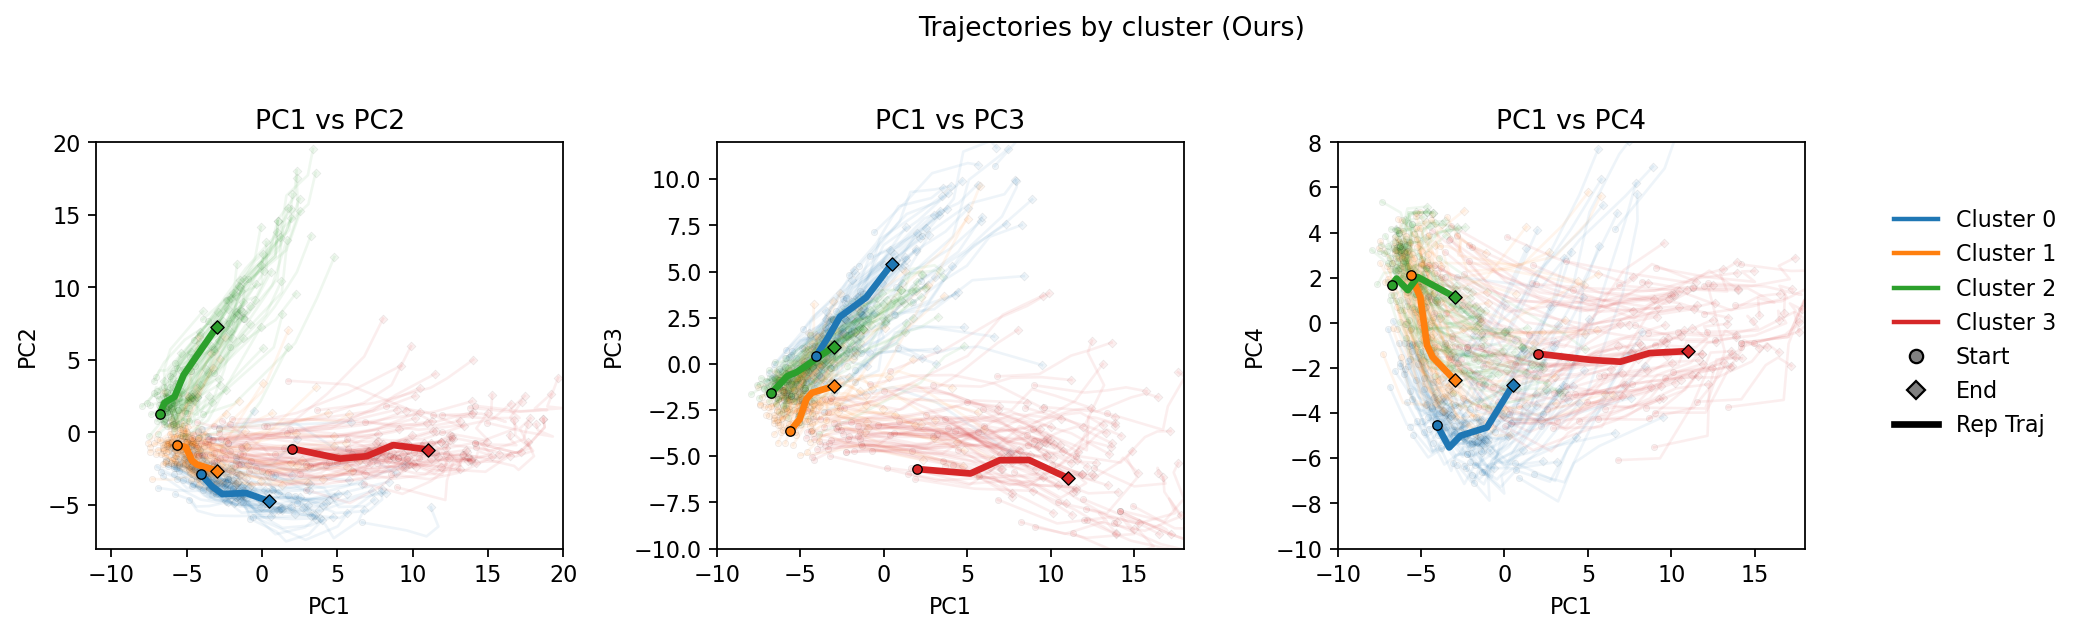

In [24]:
# traj: (T,N,D), labels: (N,), DM: (N,N)
medoids = plot_clusters_1x3_from_pcs_with_medoids(
    traj_reg, lab_reg_km, DM_reg,
    title = "Trajectories by cluster (Ours)",
    per_cluster_max=100,      # optional cap for readability
    alpha_all=0.075,           # all trajectories have alpha 0.15
    s_markers=True            # show start/end markers
)

In [25]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

def embed_mds(DM, n_components=10, random_state=0):
    DM = _check_dm(DM)
    X_emb = MDS(n_components=n_components, dissimilarity='precomputed',
                random_state=random_state, n_init=4).fit_transform(DM)
    return X_emb

# -------------------- (1) Internal validation --------------------
def internal_validation(DM, labels, emb=None, n_components=10):
    """
    Returns: dict with silhouette (precomputed), Davies–Bouldin (on embedding), Dunn index
    """
    DM = _check_dm(DM)
    # Silhouette on distances (higher is better)
    sil = silhouette_score(DM, labels, metric="precomputed")

    # DBI needs coordinates; embed if not given
    if emb is None:
        emb = embed_mds(DM, n_components=n_components)
    dbi = davies_bouldin_score(emb, labels)  # lower is better

    return {"silhouette": sil, "davies_bouldin": dbi}


# -------------------- (2) Stability (bootstrap ARI) --------------------
def stability_kmeans_from_dist(
    DM, n_clusters, n_components=10, n_boot=20, subsample=0.8, random_state=0
):
    """
    Bootstrap/subsample stability:
      - For each bootstrap b, sample ~subsample*N indices
      - Embed that submatrix with MDS
      - K-means → labels_b on subset
      - Compute pairwise ARIs across bootstraps on overlapping indices
    Returns: {'mean_ari': ..., 'all_aris': array}
    """
    rng = np.random.default_rng(random_state)
    DM = _check_dm(DM)
    N = DM.shape[0]
    m = max(2, int(round(subsample * N)))

    subs = []
    labels_list = []

    for b in range(n_boot):
        idx = np.sort(rng.choice(N, size=m, replace=False))
        X_emb = embed_mds(DM[np.ix_(idx, idx)], n_components=n_components,
                          random_state=(random_state + b))
        lab = KMeans(n_clusters=n_clusters, n_init=20,
                     random_state=(random_state + b)).fit_predict(X_emb)
        subs.append(idx)
        labels_list.append(lab)

    # pairwise ARIs on intersections
    aris = []
    for a in range(n_boot):
        for b in range(a+1, n_boot):
            idx_a, idx_b = subs[a], subs[b]
            inter, ia, ib = np.intersect1d(idx_a, idx_b, assume_unique=True, return_indices=True)
            if len(inter) >= 2:
                aris.append(adjusted_rand_score(labels_list[a][ia], labels_list[b][ib]))
    return {"mean_ari": float(np.mean(aris)) if aris else np.nan, "all_aris": np.array(aris)}

# -------------------- (3) Intra/Inter distance stats --------------------
def intra_inter_stats(DM, labels):
    """
    Returns per-cluster intra mean, global intra mean, inter mean, and separation ratio.
    """
    DM = _check_dm(DM)
    labels = np.asarray(labels)
    uniq = np.unique(labels)

    intra_means = []
    for c in uniq:
        idx = np.where(labels == c)[0]
        if len(idx) <= 1:
            intra_means.append(0.0)
        else:
            D_sub = DM[np.ix_(idx, idx)]
            vals = D_sub[np.triu_indices_from(D_sub, k=1)]
            intra_means.append(float(np.mean(vals)))

    # global inter-cluster mean (across all pairs in different clusters)
    mask_inter = labels[:, None] != labels[None, :]
    inter_vals = DM[mask_inter]
    inter_mean = float(np.mean(inter_vals)) if inter_vals.size else np.nan

    intra_global = float(np.mean(intra_means)) if len(intra_means) else np.nan
    sep_ratio = inter_mean / intra_global if intra_global > 0 else np.inf

    return {
        "intra_means_per_cluster": np.array(intra_means),
        "intra_mean_global": intra_global,
        "inter_mean_global": inter_mean,
        "separation_ratio": sep_ratio,  # higher is better
    }


In [26]:
# 1) Internal validation
reg_scores  = internal_validation(DM_reg,    lab_reg_km,  emb=emb_reg,  n_components=10)
dir_scores  = internal_validation(DM_direct, lab_dir_km,  emb=emb_dir,  n_components=10)
print("Internal validation (reg):", reg_scores)
print("Internal validation (dir):", dir_scores)

Internal validation (reg): {'silhouette': np.float64(0.24354047672135995), 'davies_bouldin': np.float64(1.3385059974018447)}
Internal validation (dir): {'silhouette': np.float64(0.21082366062585292), 'davies_bouldin': np.float64(1.4353733253150611)}


- Elbow methods: ~ 10mins

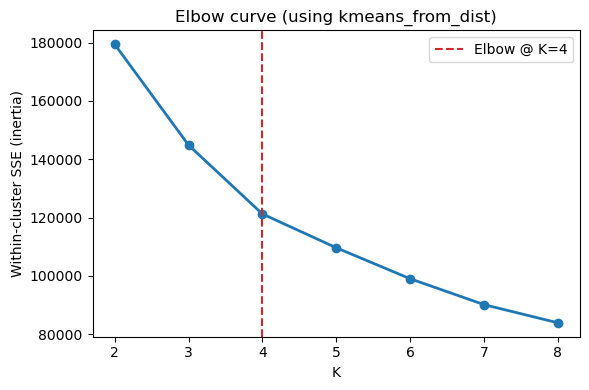

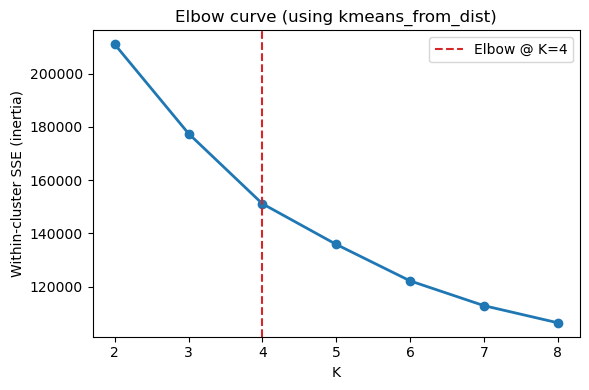

Suggested K (reg): 4
Suggested K (direct): 4


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

# ---------- Elbow using your kmeans_from_dist ----------
def elbow_from_dist(DM, k_min=1, k_max=12, n_components=10, random_state=0, auto_knee=True):
    Ks, inertias = [], []
    all_labels = {}
    all_embeds = {}

    for k in range(k_min, k_max + 1):
        # use your kmeans_from_dist function
        labels, X_emb = kmeans_from_dist(DM, n_clusters=k, n_components=n_components, random_state=random_state)
        # compute inertia (WCSS) manually
        inertia = 0.0
        for cluster in np.unique(labels):
            Xc = X_emb[labels == cluster]
            if len(Xc) > 0:
                center = Xc.mean(axis=0)
                inertia += ((Xc - center) ** 2).sum()
        Ks.append(k)
        inertias.append(inertia)
        all_labels[k] = labels
        all_embeds[k] = X_emb

    Ks = np.array(Ks)
    inertias = np.array(inertias)

    # Plot elbow
    plt.figure(figsize=(6,4))
    plt.plot(Ks, inertias, 'o-', lw=2)
    plt.xlabel("K")
    plt.ylabel("Within-cluster SSE (inertia)")
    plt.title("Elbow curve (using kmeans_from_dist)")
    knee_k = None
    if auto_knee:
        kl = KneeLocator(Ks, inertias, curve="convex", direction="decreasing")
        knee_k = kl.knee
        if knee_k is not None:
            plt.axvline(knee_k, ls="--", c="tab:red", label=f"Elbow @ K={knee_k}")
            plt.legend()
    plt.tight_layout()
    plt.show()

    return Ks, inertias, knee_k, all_labels, all_embeds

# ---------------- Example usage ----------------
Ks_reg, inert_reg, knee_reg, lab_reg, emb_reg = elbow_from_dist(DM_reg, k_min=2, k_max=8, n_components=10)
Ks_dir, inert_dir, knee_dir, lab_dir, emb_dir = elbow_from_dist(DM_direct, k_min=2, k_max=8, n_components=10)

print("Suggested K (reg):", knee_reg)
print("Suggested K (direct):", knee_dir)


## differential expression analysis

In [27]:
# DE analysis for the initial points

# Load the transport maps for all 8 steps
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/statefate/Trajectories/direct20/T_map_{i+1}_to_{i+2}.pt") for i in range(2)]

# Sample 10 points from Ysamplers_new[0]
data = torch.from_numpy(np.load(result_folder+"results/dynamics/statefate/starting3000.npy"))

# Convert data to numpy for visualization
trajectory = [data.detach().numpy()]

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

traj_direct = np.array(trajectory) 

In [28]:
# Load the transport maps for all 8 steps
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/statefate/Trajectories/reg20/T_map_{i+1}_to_{i+2}.pt") for i in range(4)]

# # Sample 10 points from Ysamplers_new[0]
data = torch.from_numpy(np.load(result_folder+"results/dynamics/statefate/starting3000.npy"))

# Convert data to numpy for visualization
trajectory = [data.detach().numpy()]

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

traj_reg = np.array(trajectory) 

In [29]:
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
traj3= np.load(result_folder+"results/dynamics/statefate/trajs_statefate_full_mioflow.npy")
print(traj3.shape)

# traj3: (100, 10, 20)  [time, traj, dim]
T = traj3.shape[0]

# pick 9 almost-equally spaced indices from [0, T-1], including endpoints
idx = np.rint(np.linspace(0, T - 1, num=5)).astype(int)
# safety: force endpoints (just in case)
idx[0], idx[-1] = 0, T - 1

traj_mioflow = traj3[idx, :, :]   # (9, 10, 20)

print("chosen time indices:", idx.tolist())
print("trajectory_3 shape:", traj_mioflow.shape)

(25, 3000, 20)
chosen time indices: [0, 6, 12, 18, 24]
trajectory_3 shape: (5, 3000, 20)


In [30]:
def pairwise_aligned_euclid(traj):
    """
    Average Euclidean distance at corresponding time steps.
    Requires same T across trajectories.
    """
    T, N, D = traj.shape
    DM = np.zeros((N, N), dtype=float)
    for i in range(N):
        Xi = traj[:, i, :]  # (T,D)
        for j in range(i+1, N):
            Xj = traj[:, j, :]
            d = np.linalg.norm(Xi - Xj, axis=1).mean()
            DM[i,j] = DM[j,i] = float(d)
    return DM
DM_reg_eucl    = pairwise_aligned_euclid(traj_reg)
DM_direct_eucl = pairwise_aligned_euclid(traj_direct)

DM_reg    = DM_reg_eucl      # or DM_reg_lcss, DM_reg_eucl
DM_direct = DM_direct_eucl   

In [31]:
DM_mioflow_eucl = pairwise_aligned_euclid(traj_mioflow)
DM_mioflow = DM_mioflow_eucl

In [32]:
pur_reg_mean, pur_reg_all, _ = neighborhood_purity_euclid(traj_reg, k=10, start_t=0, DM=DM_reg)
pur_dir_mean, pur_dir_all, _ = neighborhood_purity_euclid(traj_direct, k=10, start_t=0, DM=DM_direct)
pur_mioflow_mean, pur_mioflow_all, _ = neighborhood_purity_euclid(traj_mioflow, k=10, start_t=0, DM=DM_mioflow)

print("Purity (lower=better):  reg =", pur_reg_mean, "  direct =", pur_dir_mean, " mioflow =", pur_mioflow_mean)

Purity (lower=better):  reg = 4.476723951756954   direct = 5.57129490190347  mioflow = 3.3181856349448364


In [33]:
# --- K-means via MDS ---
lab_reg_km,  emb_reg  = kmeans_from_dist(DM_reg,    n_clusters=4, n_components=10)
lab_dir_km,  emb_dir  = kmeans_from_dist(DM_direct, n_clusters=4, n_components=10)

In [34]:
lab_mioflow_km,  emb_mioflow  = kmeans_from_dist(DM_mioflow,    n_clusters=4, n_components=10)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clusters_1x3_from_pcs_with_medoids(
    traj, labels, DM,
    title="Trajectories by cluster (PC planes) + medoids",
    linewidth=1.2, alpha_all=0.1, s_markers=True,
    per_cluster_max=None, random_state=0,
    start_marker='o', end_marker='D',
    start_size=8, end_size=8,
    medoid_linewidth=3.0, medoid_start_size=18, medoid_end_size=18,
    return_details=False
):
    """
    traj:   (T, N, D) array (D>=4), columns are PCs.
    labels: (N,) cluster labels (ints or strings).
    DM:     (N, N) pairwise distance matrix between trajectories.

    Draws 1×3 panel: (PC1,PC2) | (PC1,PC3) | (PC1,PC4)
    - All trajectories plotted with alpha=alpha_all (default 0.15).
    - Per cluster, the 'mean trajectory' (medoid: min row-sum in cluster's DM) is
      overplotted with thicker line and larger markers (but same alpha).

    Returns (if return_details=True):
      medoid_idx: dict[c] -> global index of medoid trajectory
      subDMs:     dict[c] -> cluster sub-distance matrix (n_c × n_c)
      plotted_indices_by_cluster: dict[c] -> indices actually plotted for that cluster
    """
    T, N, D = traj.shape
    assert D >= 4, "Need at least 4 PCs (columns) to draw the 1×3 grid."
    assert DM.shape == (N, N), "DM must be (N, N)."

    # PC index pairs (0-based) — first row only
    pairs = [(0,1), (0,2), (0,3)]

    uniq = np.unique(labels)
    cmap = plt.get_cmap('tab10')
    color_map = {c: cmap(i % 10) for i, c in enumerate(uniq)}

    # ---- compute medoid per cluster & store sub-distance matrices
    medoid_idx = {}
    subDMs = {}
    idx_by_cluster_full = {}

    for c in uniq:
        ids = np.where(labels == c)[0]
        idx_by_cluster_full[c] = ids
        subDM = DM[np.ix_(ids, ids)]
        subDMs[c] = subDM
        # medoid = argmin row-sum
        sums = subDM.sum(axis=1)
        medoid_local = int(np.argmin(sums))
        medoid_idx[c] = int(ids[medoid_local])

    # (optional) cap trajectories per cluster for display — ensure medoid is included
    rng = np.random.default_rng(random_state)
    plot_indices_by_cluster = {}
    for c in uniq:
        ids = idx_by_cluster_full[c]
        if per_cluster_max is not None and len(ids) > per_cluster_max:
            # sample without the medoid first
            ids_wo_med = ids[ids != medoid_idx[c]]
            keep = rng.choice(ids_wo_med, size=per_cluster_max-1, replace=False)
            ids_plot = np.concatenate([keep, [medoid_idx[c]]])
        else:
            ids_plot = ids
        plot_indices_by_cluster[c] = np.array(sorted(ids_plot))

    # ---- plotting
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=160)
    axes = np.atleast_1d(axes).ravel()

    for ax, (p, q) in zip(axes, pairs):
        for c in uniq:
            col = color_map[c]
            ids_plot = plot_indices_by_cluster[c]
            m_idx = medoid_idx[c]

            # 1) draw all cluster trajectories (alpha=alpha_all)
            for i in ids_plot:
                x = traj[:, i, p]
                y = traj[:, i, q]
                ax.plot(x, y, color=col, lw=linewidth, alpha=alpha_all)
                if s_markers:
                    ax.scatter(x[0],  y[0],
                               color=col, s=start_size,
                               marker=start_marker,
                               edgecolors='k', linewidths=0.3, zorder=3, alpha=alpha_all)
                    ax.scatter(x[-1], y[-1],
                               color=col, s=end_size,
                               marker=end_marker,
                               edgecolors='k', linewidths=0.3, zorder=3, alpha=alpha_all)

            # 2) overplot the medoid for this cluster (thicker & larger, same alpha)
            x = traj[:, m_idx, p]
            y = traj[:, m_idx, q]
            ax.plot(x, y, color=col, lw=medoid_linewidth, alpha=1, zorder=4)
            if s_markers:
                ax.scatter(x[0],  y[0],
                           color=col, s=medoid_start_size,
                           marker=start_marker,
                           edgecolors='k', linewidths=0.6, zorder=5, alpha=1)
                ax.scatter(x[-1], y[-1],
                           color=col, s=medoid_end_size,
                           marker=end_marker,
                           edgecolors='k', linewidths=0.6, zorder=5, alpha=1)

        if q == 1:
            xlim = (-11, 20)
            ylim = (-8, 20)
        elif q == 2 :
            xlim = (-10, 18)
            ylim = (-10, 12)   
        else:
            xlim = (-10, 18)
            ylim = (-10, 8) 
        ax.set_xlim(*xlim)             # <-- fixed X limits
        ax.set_ylim(*ylim)   

        ax.set_xlabel(f"PC{p+1}")
        ax.set_ylabel(f"PC{q+1}")
        ax.set_title(f"PC{p+1} vs PC{q+1}")
        ax.grid(False)

    # --- Legend: move outside to the RIGHT, centered vertically
    handles = [plt.Line2D([0],[0], color=color_map[c], lw=2, label=f"Cluster {c}") for c in uniq]
    handles += [
        plt.Line2D([0],[0], marker=start_marker, color='w', markerfacecolor='gray',
                   markeredgecolor='k', label='Start', markersize=6, linewidth=0),
        plt.Line2D([0],[0], marker=end_marker, color='w', markerfacecolor='gray',
                   markeredgecolor='k', label='End', markersize=6, linewidth=0),
        plt.Line2D([0],[0], color='k', lw=medoid_linewidth, label='Rep Traj'),
    ]

    # leave room on the right for the legend
    plt.subplots_adjust(right=0.82)
    fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.84, 0.5),
               frameon=False, ncol=1)

    fig.suptitle(title, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.82, 0.95])
    plt.show()

    if return_details:
        return medoid_idx


In [36]:
import numpy as np
from itertools import permutations

def unify_labels_by_permutation(reference, to_align):
    """
    Brute-force: try all permutations of mapping from `to_align`'s unique labels
    to `reference`'s unique labels, pick the mapping with maximum matches.

    Parameters
    ----------
    reference : array-like of shape (N,)
        Canonical labels (e.g., lab_reg_km).
    to_align : array-like of shape (N,)
        Labels to relabel to match `reference` (e.g., lab_dir_km).

    Returns
    -------
    aligned : np.ndarray of shape (N,)
        `to_align` relabeled according to the best mapping.
    mapping : dict
        Mapping from original labels in `to_align` -> labels in `reference`.
    info : dict
        {"best_matches": int, "accuracy": float, "k": int, "unique_ref": np.ndarray, "unique_align": np.ndarray}
    """
    a = np.asarray(reference)
    b = np.asarray(to_align)
    if a.shape != b.shape:
        raise ValueError("Both label arrays must have the same length.")

    # Unique labels (order matters only for permutations; keep them sorted for determinism)
    ua = np.unique(a)   # labels present in reference
    ub = np.unique(b)   # labels present in to_align

    if len(ua) != len(ub):
        raise ValueError(f"Number of clusters differ: ref={len(ua)} vs to_align={len(ub)}; "
                         "permutation-based unification assumes equal K.")

    K = len(ua)
    N = len(a)

    best_matches = -1
    best_perm = None

    # Try every one-to-one mapping (ub[j] -> perm[j])
    for perm in permutations(ua, K):
        # Build mapping dict: each label in `to_align` maps to a label in `reference`
        m = {ub[j]: perm[j] for j in range(K)}
        # Apply mapping quickly
        mapped = np.array([m[x] for x in b])
        matches = int(np.sum(mapped == a))
        if matches > best_matches:
            best_matches = matches
            best_perm = perm

    # Rebuild mapping with the winning permutation and produce aligned labels
    mapping = {ub[j]: best_perm[j] for j in range(K)}
    aligned = np.array([mapping[x] for x in b])
    acc = best_matches / N

    info = {
        "best_matches": best_matches,
        "accuracy": acc,
        "k": K,
        "unique_ref": ua,
        "unique_align": ub,
    }
    return aligned, mapping, info


In [37]:
aligned_dir, mapping, info = unify_labels_by_permutation(lab_reg_km, lab_dir_km)
print("Mapping (dir -> reg):", mapping)
print("Accuracy after relabel:", info["accuracy"])

Mapping (dir -> reg): {np.int32(0): np.int32(1), np.int32(1): np.int32(0), np.int32(2): np.int32(3), np.int32(3): np.int32(2)}
Accuracy after relabel: 0.821


In [38]:
aligned_mioflow, mapping, info = unify_labels_by_permutation(lab_reg_km, lab_mioflow_km)
print("Mapping (dir -> reg):", mapping)
print("Accuracy after relabel:", info["accuracy"])

Mapping (dir -> reg): {np.int32(0): np.int32(0), np.int32(1): np.int32(3), np.int32(2): np.int32(2), np.int32(3): np.int32(1)}
Accuracy after relabel: 0.7453333333333333


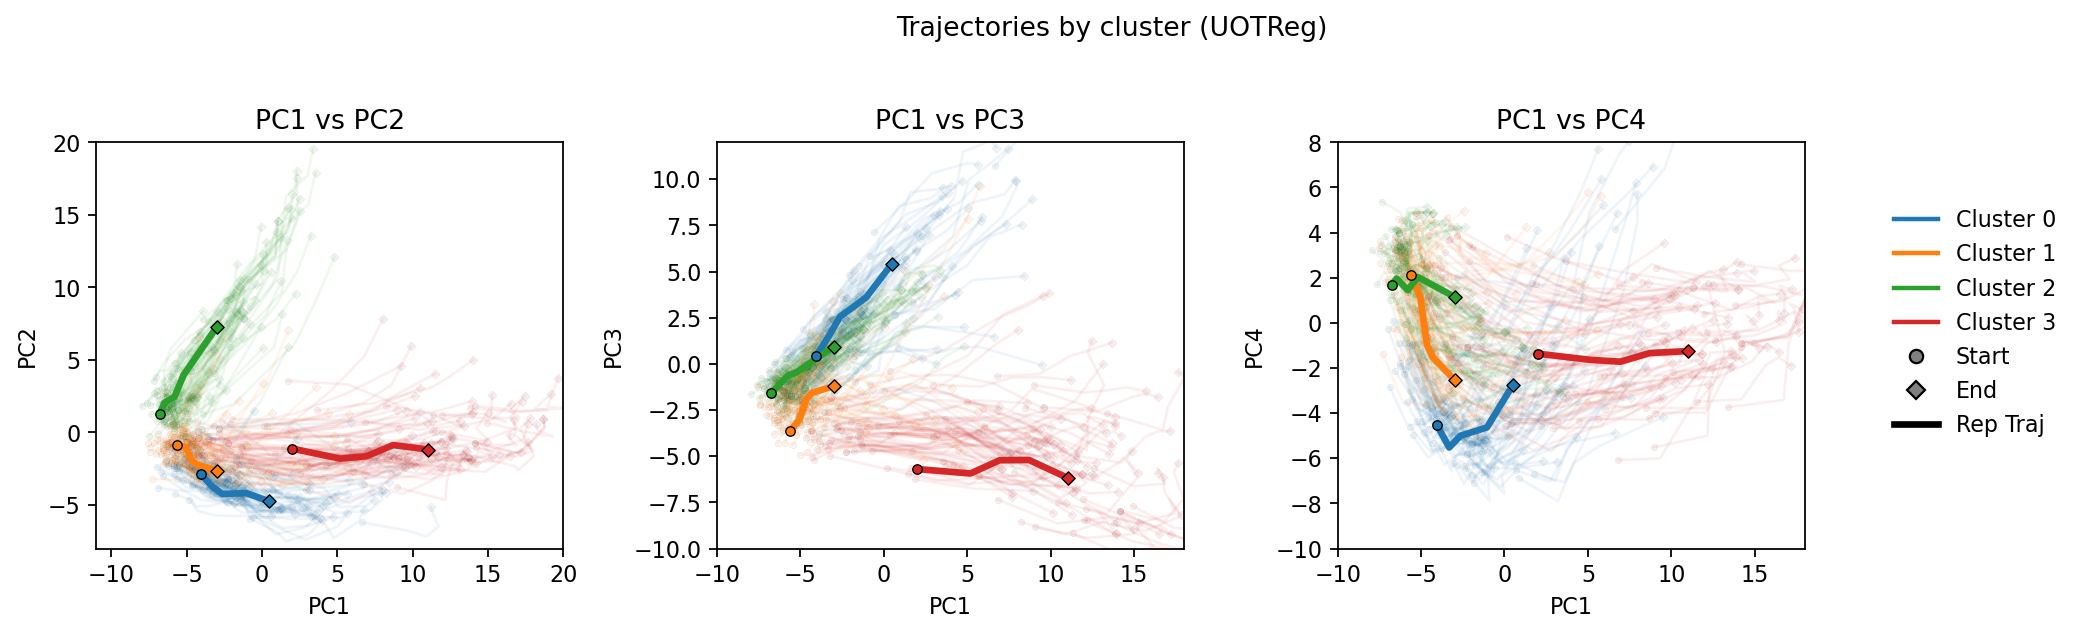

In [39]:
# traj: (T,N,D), labels: (N,), DM: (N,N)
medoids = plot_clusters_1x3_from_pcs_with_medoids(
    traj_reg, lab_reg_km, DM_reg,
    title = "Trajectories by cluster (UOTReg)",
    per_cluster_max=100,      # optional cap for readability
    alpha_all=0.075,           # all trajectories have alpha 0.15
    s_markers=True            # show start/end markers
)


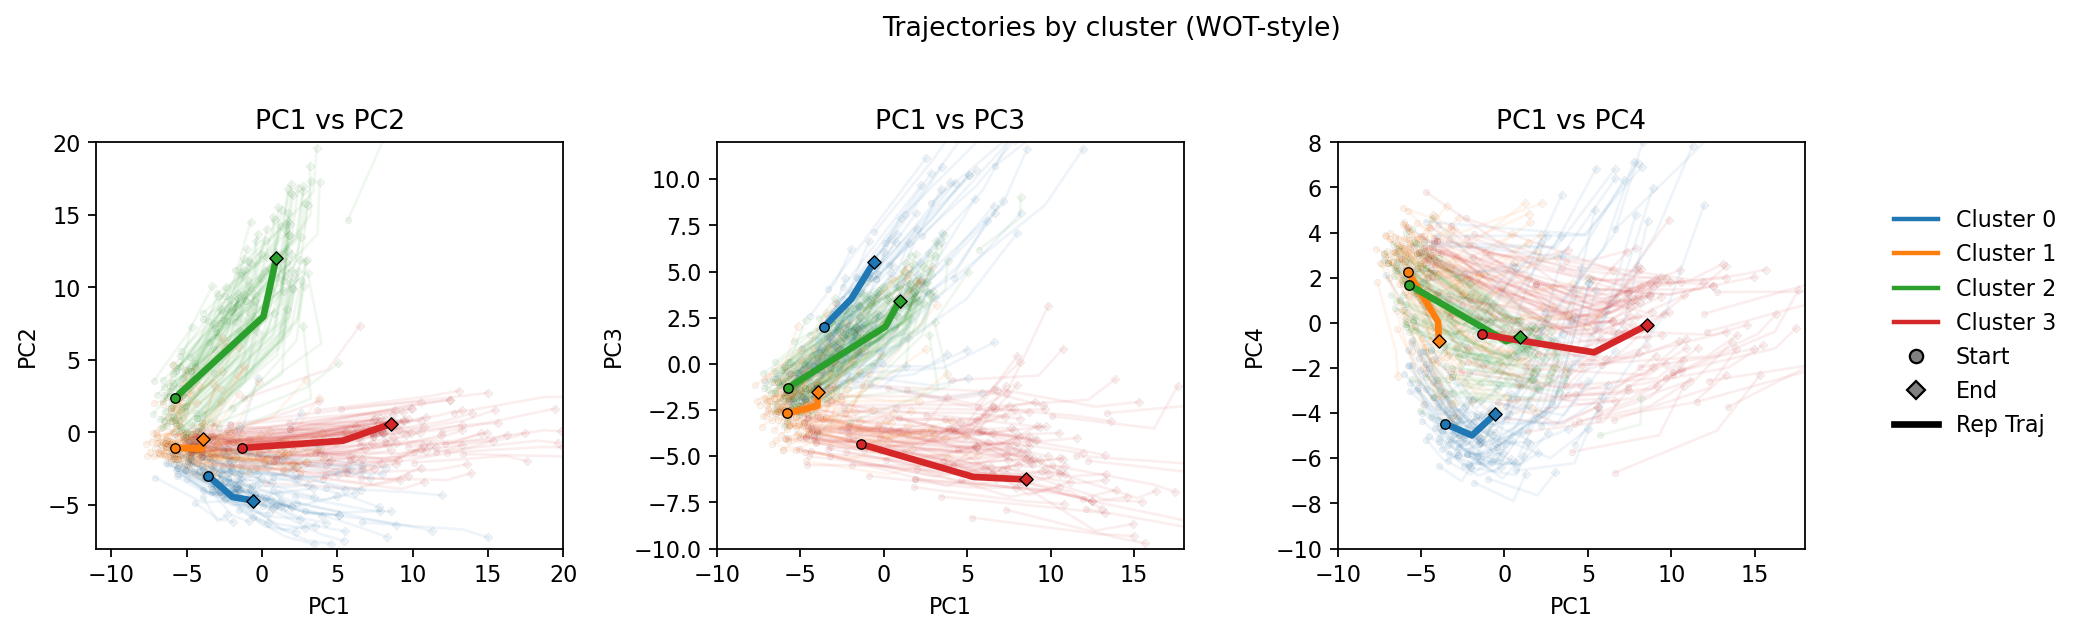

In [40]:
# traj: (T,N,D), labels: (N,), DM: (N,N)
medoids = plot_clusters_1x3_from_pcs_with_medoids(
    traj_direct, aligned_dir, DM_direct,
    title = "Trajectories by cluster (WOT-style)",
    per_cluster_max=100,      # optional cap for readability
    alpha_all=0.075,           # all trajectories have alpha 0.15
    s_markers=True            # show start/end markers
)

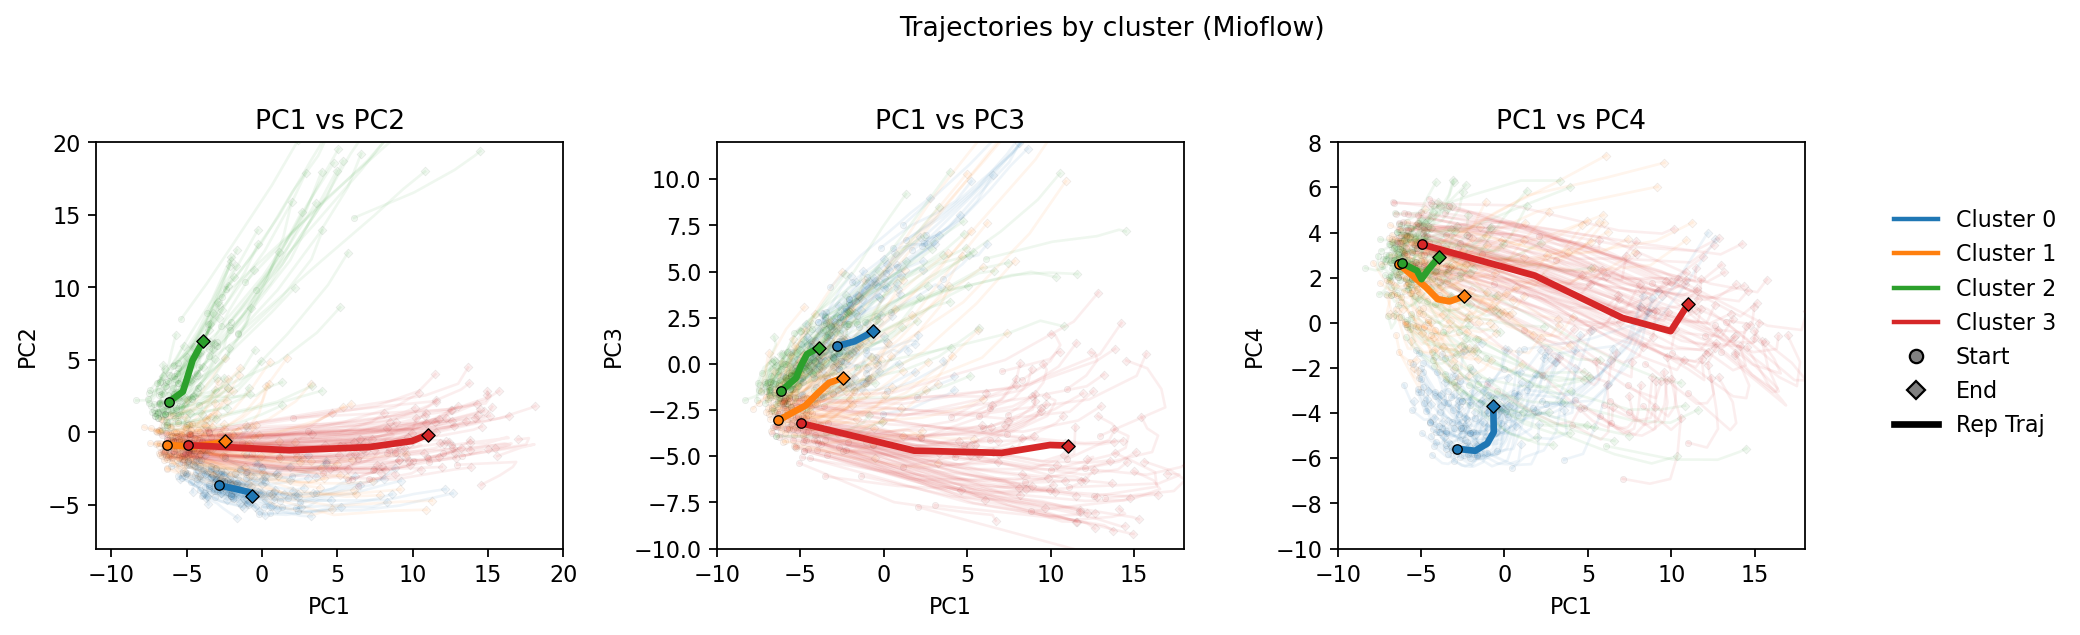

In [41]:
# traj: (T,N,D), labels: (N,), DM: (N,N)
medoids = plot_clusters_1x3_from_pcs_with_medoids(
    traj_mioflow, aligned_mioflow, DM_mioflow,
    title="Trajectories by cluster (Mioflow)",
    per_cluster_max=100,      # optional cap for readability
    alpha_all=0.075,           # all trajectories have alpha 0.15
    s_markers=True            # show start/end markers
)

### DE analysis for initial points

In [42]:
import numpy as np
adata_pc = statefate_pc_df[statefate.obs['time'] == 2]

# Convert pandas DataFrame to NumPy array
adata_pc_array = adata_pc.to_numpy()
data_numpy = data.detach().numpy()

# Create a dictionary mapping byte representations of rows to their indices
row_to_index = {adata_pc_array[i].tobytes(): i for i in range(adata_pc_array.shape[0])}

# Find the corresponding indices for each row in data
indices = [row_to_index[row.tobytes()] for row in data_numpy]

# Now adata_pc_array[indices] should match data (up to row order in data)
# If you need to subset the original DataFrame: adata_pc.iloc[indices]

# indices

(3000, 1622)


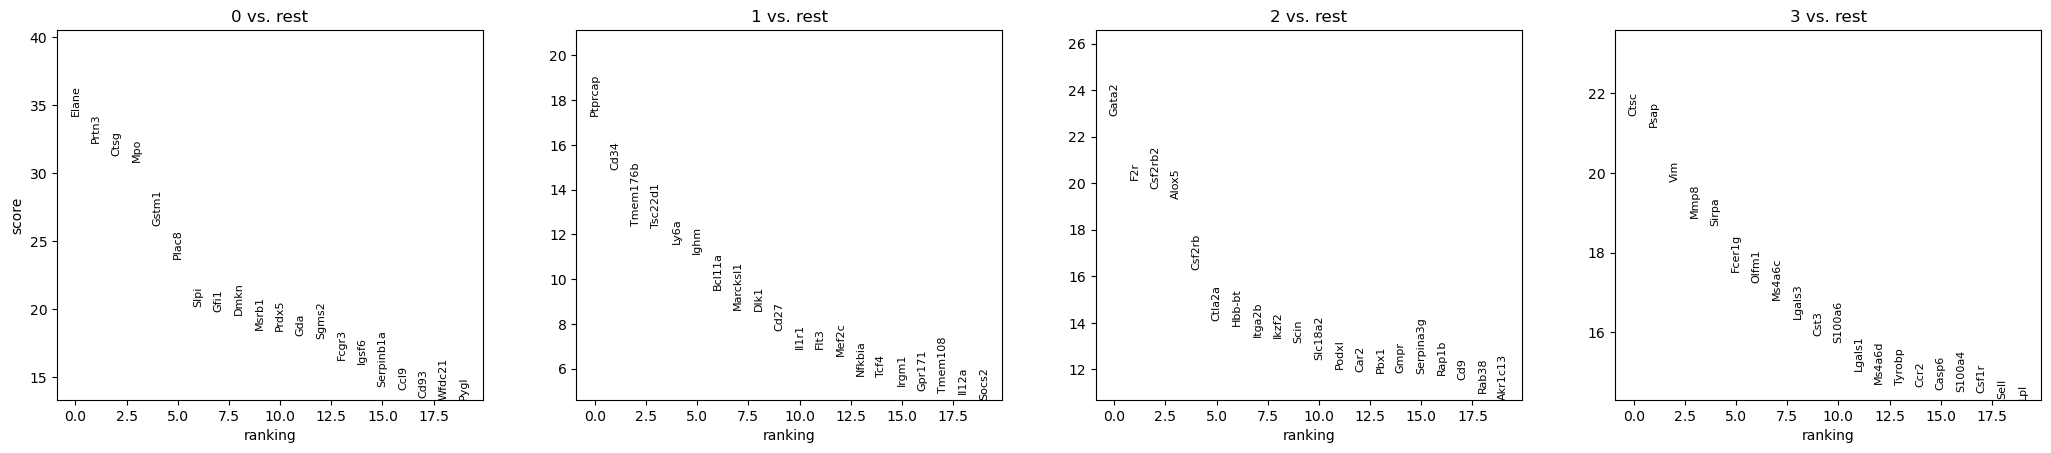

In [43]:
import scanpy as sc
import numpy as np

# Step 1: Subset AnnData to only 'Day 00-03'
adata_reg_full = statefate[statefate.obs['time'] == 2].copy()

adata_reg = adata_reg_full[indices, :].copy()
print(adata_reg.shape)

# Step 2: Add predicted cluster labels as obs column
# Make sure the number of predictions matches number of cells
assert adata_reg.shape[0] == len(lab_reg_km), "Mismatch between prediction and cell count"

# Add logistic regression cluster labels (0/1) to metadata
adata_reg.obs['traj_group'] = lab_reg_km.astype(str)  # Convert to string for categorical use

# Step 3: Run Scanpy signature gene discovery
sc.tl.rank_genes_groups(adata_reg, groupby='traj_group', method='wilcoxon')

# Step 4: Optional — visualize top genes
sc.pl.rank_genes_groups(adata_reg, n_genes=20, sharey=False)


In [44]:
import pandas as pd
import scanpy as sc

# long-form table with columns: group, names, scores, logfoldchanges, pvals, pvals_adj
df = sc.get.rank_genes_groups_df(adata_reg, group=None)  # key="rank_genes_groups" by default
print(df.head(10))  # peek

# Top 20 per group (print)
topN = 20
for g, sub in df.sort_values(["group","scores"], ascending=[True, False]).groupby("group"):
    print(f"\n=== {g} vs rest — top {topN} ===")
    print(sub.head(topN)[["names","scores","logfoldchanges","pvals_adj"]].to_string(index=False))

# (optional) save all results
# df.to_csv("rank_genes_groups_all.csv", index=False)

  group  names     scores  logfoldchanges          pvals      pvals_adj
0     0  Elane  34.256756        6.226513  3.459767e-257  5.611743e-254
1     0  Prtn3  32.210846        4.438636  1.244210e-227  1.009054e-224
2     0   Ctsg  31.288788        4.402015  6.629854e-215  3.584541e-212
3     0    Mpo  30.872519        5.369035  2.793804e-209  1.132888e-206
4     0  Gstm1  26.141188        3.607969  1.241277e-150  4.026702e-148
5     0  Plac8  23.711843        2.315563  2.721688e-124  7.357631e-122
6     0   Slpi  20.186140        3.261842   1.296022e-90   3.003068e-88
7     0   Gfi1  19.845432        4.686546   1.206865e-87   2.446920e-85
8     0   Dmkn  19.613914        3.128232   1.176198e-85   2.119770e-83
9     0  Msrb1  18.463459        2.562315   4.064558e-76   6.592712e-74

=== 0 vs rest — top 20 ===
    names    scores  logfoldchanges     pvals_adj
    Elane 34.256756        6.226513 5.611743e-254
    Prtn3 32.210846        4.438636 1.009054e-224
     Ctsg 31.288788        4.4

### Checking the ending points

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from AnnData
X_pca = statefate.obsm["X_pca"]
print(X_pca.shape)
PCs = statefate.varm["PCs"]  # shape: (n_genes, n_pcs)
print(PCs.shape)

# Define genes of interest (you can modify these)
# If it's a sparse matrix, convert row means safely
if hasattr(statefate.X, "toarray"):
    gene_means = statefate.X.mean(axis=0).A1  # A1 converts to flat array
else:
    gene_means = statefate.X.mean(axis=0)

# Reconstruct expression (approximation)
X_reconstructed = X_pca @ PCs.T + gene_means
print(X_reconstructed.shape)

(130861, 50)
(1622, 50)
(130861, 1622)


In [46]:
import numpy as np

# ---- inputs ----
# traj_pc: (T, N, 20) = your trajectories in PC space (first 20 PCs)
traj_pc = traj_reg   # rename if needed; shape should be (9, N, 20)

# ---- get the PCA pieces from AnnData ----
# PCs loadings: (n_genes, n_pcs); take first 20 columns to match traj_pc
PCs_full = statefate.varm["PCs"]            # (G, 50) in your case
PCs20 = PCs_full[:, :20]                   # (G, 20)

# gene means (same pre-processing as used for PCA: Scanpy PCA centers genes)
if hasattr(statefate.X, "toarray"):
    gene_means = statefate.X.mean(axis=0).A1   # (G,)
else:
    gene_means = np.asarray(statefate.X.mean(axis=0)).ravel()  # (G,)

G = PCs20.shape[0]
T, N, P = traj_pc.shape
assert P == PCs20.shape[1], "PC count in trajectory must match the columns taken from PCs."

# ---- map back to gene space ----
# Flatten over time * cells, multiply by loadings, then reshape back
traj_flat = traj_pc.reshape(T * N, P)           # (T*N, 20)
X_gene_flat = traj_flat @ PCs20.T               # (T*N, G)
X_gene_flat += gene_means[None, :]              # add gene means (broadcast)

traj_gene = X_gene_flat.reshape(T, N, G)        # (T, N, G)

print("Traj in gene space:", traj_gene.shape)   # expected: (9, N, G)

# ---- keep exactly 1,000 genes if you want (choose HVGs if available) ----
if "highly_variable" in statefate.var and statefate.var["highly_variable"].sum() >= 1000:
    idx_1000 = np.where(statefate.var["highly_variable"].values)[0][:1000]
else:
    idx_1000 = np.arange(min(1000, G))

# traj_gene_1000 = traj_gene[:, :, idx_1000]      # (9, N, 1000)
traj_gene_1000 = traj_gene.copy()
gene_names_1000 = statefate.var_names.to_numpy()

print("Traj in gene space (1000 genes):", traj_gene_1000.shape)
# Now traj_gene_1000 is ready for gene-level analyses/plots; gene_names_1000 gives the labels.


Traj in gene space: (5, 3000, 1622)
Traj in gene space (1000 genes): (5, 3000, 1622)


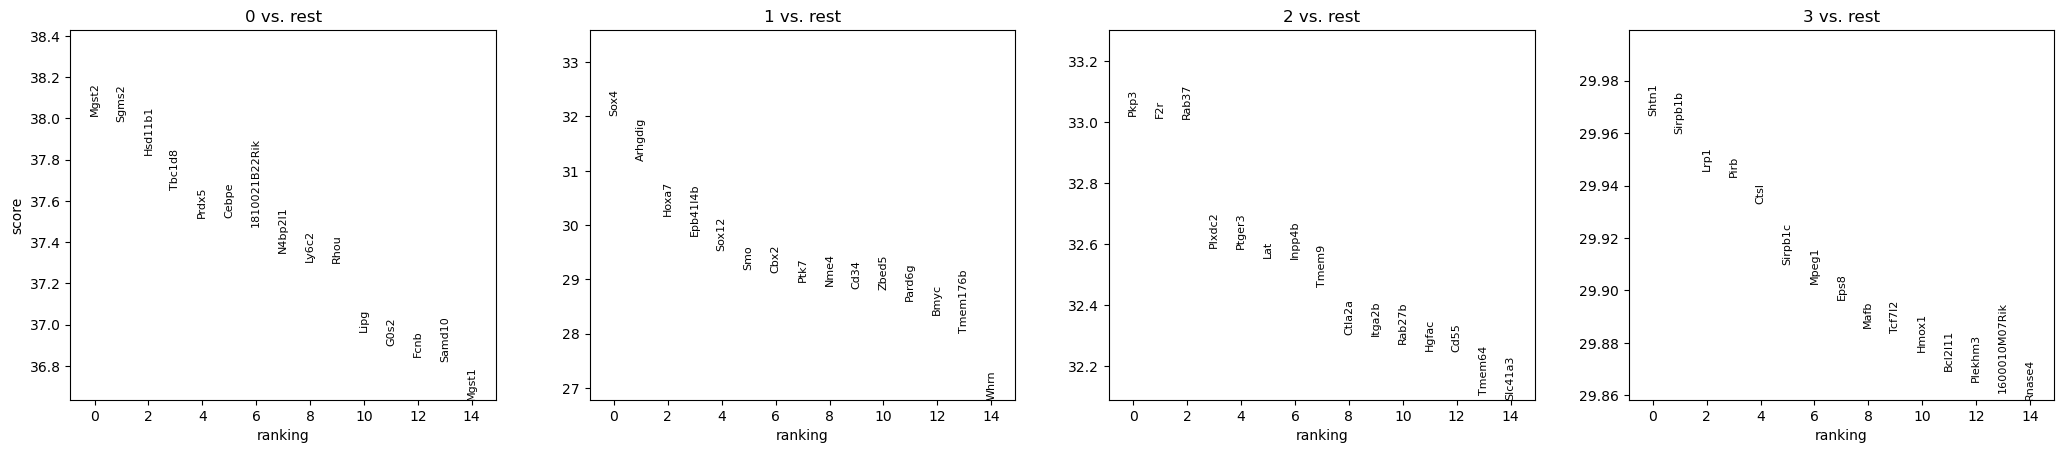

  group    names     scores  logfoldchanges          pvals      pvals_adj
0     0    Mgst2  38.014282        3.041502   0.000000e+00   0.000000e+00
1     0    Sgms2  37.985203        2.930292   0.000000e+00   0.000000e+00
2     0  Hsd11b1  37.822681        3.176058   0.000000e+00   0.000000e+00
3     0   Tbc1d8  37.655098        2.221518  2.699839e-310  1.094785e-307
4     0    Prdx5  37.519714        2.763185  4.394462e-308  1.251140e-305

=== 0 vs rest — top 20 genes (last step) ===
        names    scores  logfoldchanges     pvals_adj
        Mgst2 38.014282        3.041502  0.000000e+00
        Sgms2 37.985203        2.930292  0.000000e+00
      Hsd11b1 37.822681        3.176058  0.000000e+00
       Tbc1d8 37.655098        2.221518 1.094785e-307
        Prdx5 37.519714        2.763185 1.251140e-305
        Cebpe 37.518333        3.628128 1.251140e-305
1810021B22Rik 37.474434        1.980731 5.569000e-305
      N4bp2l1 37.348045        1.410770 5.530358e-303
        Ly6c2 37.302765 

In [47]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad


# Sanity checks
N_day0 = 3000
assert traj_gene_1000.shape[1] == N_day0, \
    f"N mismatch: traj has {traj_gene_1000.shape[1]}, Day0 has {N_day0}"
assert len(lab_reg_km) == N_day0, \
    f"Label length mismatch: {len(lab_reg_km)} vs {N_day0}"

# 2) Build AnnData from the last time point (T=8) of your trajectories
X_last = traj_gene_1000[4, :, :]              # shape (N, 1000)
X_last = X_last.astype(np.float32, copy=False)

# IMPORTANT: var names must match the columns of X_last.
# Use the same 1000 genes you selected when building traj_gene_1000.
var_names = pd.Index(gene_names_1000, name="gene")  # length 1000
obs_names = pd.Index([f"cell{i+1}" for i in range(N_day0)], name=None)

adata_traj_last = ad.AnnData(
    X=X_last,
    obs=pd.DataFrame(index=obs_names),
    var=pd.DataFrame(index=var_names)
)

# 3) Add the same group labels you used before
adata_traj_last.obs['traj_group'] = pd.Categorical(lab_reg_km.astype(str))

# 4) Run DE (Wilcoxon) on the reconstructed last-step expressions
sc.tl.rank_genes_groups(adata_traj_last, groupby='traj_group', method='wilcoxon')

# Step 4: Optional — visualize top genes
sc.pl.rank_genes_groups(adata_traj_last, n_genes=15, sharey=False)

# 5) (Optional) Inspect / export results as a table instead of a figure
df_last = sc.get.rank_genes_groups_df(adata_traj_last, group=None)
print(df_last.head())

# Example: print top 15 per group
topN = 20
for g, sub in df_last.sort_values(["group","scores"], ascending=[True, False]).groupby("group"):
    print(f"\n=== {g} vs rest — top {topN} genes (last step) ===")
    print(sub.head(topN)[["names","scores","logfoldchanges","pvals_adj"]].to_string(index=False))

# (Optional) save to CSV
# df_last.to_csv("de_last_step_traj_gene_1000.csv", index=False)


### Biological analysis of each trajecctories/ending cells

### Discovering trajectories difference

We hope to analyze each gene by a LMM model, accounting for the longitudinal correlation (make inference on population level metrics):
 - It's better to focus on marker genes & genes with relative larger abundance
 - what patterns do we want to see? How to detect? How to intepret?

In [ ]:
# import h5py
# import numpy as np

# # Your objects
# # traj_reg: ndarray of shape (9, N, 1000)
# # lab_reg_km: list length 1000 (e.g., per-gene labels)
# # statefate.var.index: Pandas Index of gene names

# # 1) Ensure proper dtypes
# traj_reg_to_save = np.asarray(traj_gene_1000, dtype=np.float32)  # smaller file, safe
# gene_names = statefate.var.index.tolist()                   # convert Index -> list

# lab_arr = np.asarray(lab_reg_km, dtype=np.float32)

# save_path = "/Path/to/your/folder"
# # 2) Write HDF5
# with h5py.File(save_path+"/traj_bundle.h5", "w") as f:
#     f.create_dataset("traj_reg", data=traj_reg_to_save, compression="gzip")

#     # gene_names as UTF-8 variable-length strings
#     str_dt = h5py.string_dtype(encoding="utf-8")
#     f.create_dataset("gene_names", data=np.asarray(gene_names, dtype=object), dtype=str_dt)

#     f.create_dataset("lab_reg_km", data=np.asarray(lab_reg_km))

### Marker genes visualization (LMM)

In [48]:
import json, pandas as pd, numpy as np
import matplotlib.pyplot as plt

def load_viz_payload(json_path):
    with open(json_path, "r") as f:
        payload = json.load(f)
    df_summ  = pd.DataFrame(payload["df_summ"])
    fe_line  = pd.DataFrame(payload["fe_line"])
    breaks   = pd.DataFrame(payload["breaks"]) if len(payload["breaks"]) else pd.DataFrame(columns=["cluster","tau_time"])
    for df in (df_summ, fe_line, breaks):
        if "cluster" in df.columns:
            df["cluster"] = df["cluster"].astype(int)
    return payload["gene"], df_summ, fe_line, breaks

def color_by_cluster(clusters):
    """Fixed mapping: tab10 indexed by the *cluster id* (0→tab10[0], 1→tab10[1], …)."""
    cmap = plt.get_cmap("tab10")
    return {int(c): cmap(int(c) % 10) for c in clusters}

def plot_lmm_1x3(json_paths, genenames, title="Per-cluster chosen models"):
    assert len(json_paths) == 3 and len(genenames) == 3

    # Build color map from the first pane's clusters
    _, df0, _, _ = load_viz_payload(json_paths[0])
    uniq = np.sort(df0["cluster"].unique())
    colors = color_by_cluster(uniq)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=160)
    axes = np.ravel(axes)

    for ax, jp, gtitle in zip(axes, json_paths, genenames):
        _, df_summ, fe_line, breaks = load_viz_payload(jp)

        for c in np.sort(df_summ["cluster"].unique()):
            col = colors[int(c)]
            dmu = df_summ[df_summ["cluster"] == c]
            dfe = fe_line[fe_line["cluster"] == c]
            dbk = breaks[breaks["cluster"] == c] if len(breaks) else pd.DataFrame(columns=["tau_time"])

            # Solid mean±SE + points (same color)
            ax.plot(dmu["time_orig"], dmu["mu"], color=col, linewidth=0.9)
            ax.scatter(dmu["time_orig"], dmu["mu"], color=col, s=14, zorder=3)
            ax.errorbar(dmu["time_orig"], dmu["mu"], yerr=dmu["se"],
                        fmt="none", ecolor=col, elinewidth=0.9, alpha=0.7, capsize=2)

            # Dashed FE line (same color)
            ax.plot(dfe["time_orig"], dfe["pred"], color=col, linewidth=1.1, linestyle="--")

            # Dotted breaks (same color)
            if len(dbk):
                for x0 in np.unique(dbk["tau_time"]):
                    ax.axvline(x=x0, color=col, linestyle=":", alpha=0.5, linewidth=1.0)

        ax.set_title(gtitle)
        ax.set_xlabel("Days")
        ax.set_ylabel("Expression")
        ax.grid(False)

    # Legend (clusters only) – labels reflect your actual ids (e.g., 0..5)
    handles = [plt.Line2D([0],[0], color=colors[int(c)], lw=2, label=f"Cluster {int(c)}") for c in uniq]
    plt.subplots_adjust(right=0.82)
    fig.legend(handles=handles, loc="center left", bbox_to_anchor=(0.84, 0.5), frameon=False, ncol=1)

    fig.suptitle(title, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.82, 0.95])
    plt.show()


In [49]:
def plot_lmm_1x4(json_paths, genenames, title="Per-cluster chosen models",
                 cluster_alphas=None):
    """
    json_paths: list[str] of length 4 (one JSON per panel)
    genenames : list[str] of length 4 (titles per panel)
    cluster_alphas: list/tuple of length 6 giving alpha for clusters 0..5.
                    If None, defaults to 1.0 for all clusters.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    assert len(json_paths) == 4 and len(genenames) == 4

    _, df0, _, _ = load_viz_payload(json_paths[0])
    uniq = np.sort(df0["cluster"].unique())
    colors = color_by_cluster(uniq)

    if cluster_alphas is None:
        alpha_map = {int(c): 1.0 for c in uniq}
    else:
        if len(cluster_alphas) != 6:
            raise ValueError("cluster_alphas must be length 6 for clusters 0..5.")
        cluster_alphas = [max(0.0, min(1.0, float(a))) for a in cluster_alphas]
        alpha_map = {int(c): cluster_alphas[int(c)] for c in uniq}

    fig, axes = plt.subplots(1, 4, figsize=(18, 4), dpi=160)
    axes = np.ravel(axes)

    for ax, jp, gtitle in zip(axes, json_paths, genenames):
        _, df_summ, fe_line, breaks = load_viz_payload(jp)

        for c in np.sort(df_summ["cluster"].unique()):
            col   = colors[int(c)]
            a_c   = alpha_map[int(c)]
            dmu   = df_summ[df_summ["cluster"] == c]
            dfe   = fe_line[fe_line["cluster"] == c]
            dbk   = breaks[breaks["cluster"] == c] if len(breaks) else pd.DataFrame(columns=["tau_time"])

            ax.plot(dmu["time_orig"], dmu["mu"], color=col, linewidth=0.9, alpha=a_c)
            ax.scatter(dmu["time_orig"], dmu["mu"], color=col, s=14, zorder=3, alpha=a_c)
            ax.errorbar(dmu["time_orig"], dmu["mu"], yerr=dmu["se"],
                        fmt="none", ecolor=col, elinewidth=0.9,
                        alpha=min(a_c, 0.85), capsize=2)
            ax.plot(dfe["time_orig"], dfe["pred"], color=col, linewidth=1.1,
                    linestyle="--", alpha=a_c)

            if len(dbk):
                for x0 in np.unique(dbk["tau_time"]):
                    ax.axvline(x=x0, color=col, linestyle=":", linewidth=1.0,
                               alpha=min(a_c, 0.55))

        ax.set_title(gtitle)
        ax.set_xlabel("Days")
        ax.set_ylabel("Expression")
        ax.grid(False)

    cluster_handles = [
        plt.Line2D([0],[0], color=colors[int(c)], lw=2, label=f"Cluster {int(c)}")
        for c in uniq
    ]
    style_handles = [
        plt.Line2D([0],[0], color="k", lw=1.6, linestyle="-",  label="Mean data"),
        plt.Line2D([0],[0], color="k", lw=1.6, linestyle="--", label="LMM"),
    ]
    handles = cluster_handles + style_handles

    plt.subplots_adjust(right=0.82)
    fig.legend(handles=handles, loc="center left", bbox_to_anchor=(0.84, 0.5),
               frameon=False, ncol=1)

    fig.suptitle(title, y=0.98)
    plt.tight_layout(rect=[0, 0.0, 0.82, 0.95])
    plt.show()


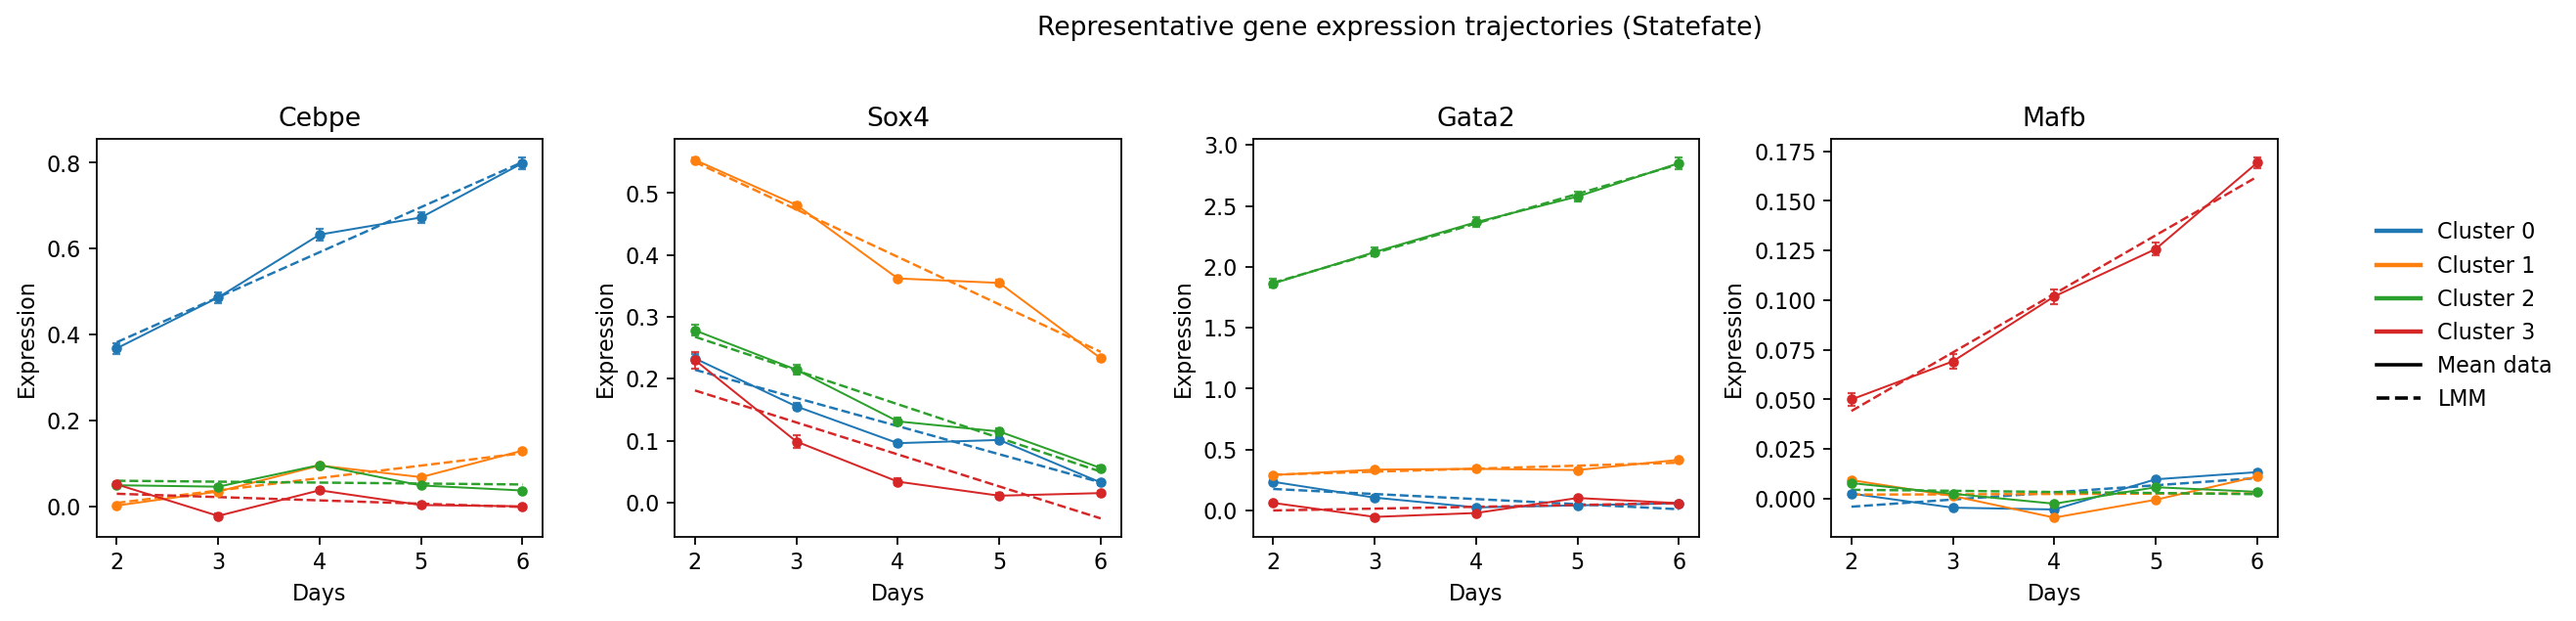

In [50]:
# ----- Example usage (repeat the same gene three times to preview style) -----
alphas = [1, 1, 1, 1, 1, 1]
genenames = ["Cebpe", "Sox4", "Gata2", "Mafb"]

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
json_paths = [result_folder+"results/dynamics/statefate/LMM/Cebpe_lmm_viz.json",
              result_folder+"results/dynamics/statefate/LMM/Sox4_lmm_viz.json",
              result_folder+"results/dynamics/statefate/LMM/Gata2_lmm_viz.json",
              result_folder+"results/dynamics/statefate/LMM/Mafb_lmm_viz.json"]   # same file for demo panes
plot_lmm_1x4(json_paths, genenames, title="Representative gene expression trajectories (Statefate)", cluster_alphas=alphas)